# DFINE Tutorial
## Overview

DFINE, which stands for **Dynamical Flexible Inference for Nonlinear Embeddings**, is a neural network model that is developed to enable flexible inference, whether causally, non-causally, or even in the presence of missing neural observations. To enable flexible inference, a model must achieve all the following operations simultaneously, without the need to retrain a new model or change the inference structure:

1\) Causal inference (filtering) <br>
2\) Non-causal inference (smoothing) <br>
3\) Account for missing observations, which can occur in wireless neural interfaces

DFINE achieves flexible inference. Also, DFINE’s inference is recursive and thus computationally efficient. Flexible inference is essential for developing neurotechnology, such as brain-machine interfaces (BMIs).

### Model Architecture
To achieve flexible inference, DFINE separates the model into jointly trained manifold and dynamic latent factors such that nonlinearity is captured through the manifold factors and the dynamics can be modeled in tractable linear form on this nonlinear manifold. Also, as its training loss, DFINE can use the future-step-ahead neural prediction error because of its flexible inference capability that allows it to efficiently and recursively compute this loss during training.

Specifically, we define the two sets of latent factors as follows: 1) Manifold latent factors ${a}_t \in \mathbb{R}^{n_a \times 1}$ and 2) Dynamic latent factors ${x}_t \in \mathbb{R}^{n_x \times 1}$.

First, the dynamic latent factors evolve in time with a linear Gaussian model: $\begin{equation}{x}_{t+1} = A{x}_t + {w}_t\tag{1}\end{equation}$ where $A \in \mathbb{R}^{n_x \times n_x}$ is the state transition matrix and ${w}_t \in \mathbb{R}^{n_x \times 1}$ is zero-mean Gaussian noise with covariance matrix $W \in \mathbb{R}^{n_x \times n_x}$. The manifold latent factors ${a}_t$ are related to the dynamic latent factors ${x}_t$ as: $\begin{equation}{a}_t = C{x}_t + {r}_t\tag{2}\end{equation}$ where $C \in \mathbb{R}^{n_a \times n_x}$ is the emission matrix and ${r}_t \times \mathbb{R}^{n_a \times 1}$ is white Gaussian noise with covariance matrix $R \in \mathbb{R}^{n_a \times n_a}$. Equations (1) and (2) form an LDM with learnable parameters $\psi = \{ A, C, W, R, {\mu}_0, \Lambda_0 \}$ where ${\mu}_0$ and $\Lambda_0$ are the initial estimate and covariance of dynamic latent factors, respectively.

Second, to model nonlinear mappings, we used MLP autoencoders to learn the mapping between neural observations ${y}_t$ and manifold latent factors ${a}_t$. We model the decoder part as a nonlinear mapping $f_\theta(\cdot)$ from manifold latent factors to neural observations: $\begin{equation}{y}_t = f_\theta({a}_t) + {v}_t\tag{3}\end{equation}$ where $\theta$ are parameters and ${v}_t \in \mathbb{R}^{n_y \times 1}$ is a white Gaussian noise with covariance $V \in \mathbb{R}^{n_y \times n_y}$. Equations (1)-(3) together form the generative model.

For inference, we also need the mapping from ${y}_t$ to ${a}_t$, which we characterize as: $\begin{equation}{a}_t = f_\phi ({y}_t)\tag{4}\end{equation}$ where $f_\phi(\cdot)$ represents the encoder in the autoencoder structure and is parameterized by another MLP. All equations above are trained together end-to-end, rather than separately. Further, the middle manifold layer in equation (2) explicitly incorporates a
stochastic noise variable $r_t$, whose covariance is learned during training, allowing the nonlinearity with respect to the dynamic latent factors to be stochastic in DFINE. To help with robustness to noise and stochasticity during inference, DFINE learns all the stochastic noise distribution parameters during training, which are then explicitly accounted for at inference.


### The Inference Problem
Using the equations above, we can infer both the manifold and dynamic latent factors from neural observations ${y}_{1:T}$, where $T$ is the total number of time steps for the observations. We use subscript $t|k$ to denote the inferred latent factors at time $t$ given observations up to time $k$, ${y}_{1:k}$. Thus, $t|t$ denotes filtering (causal) inference given ${y}_{1:t}$, $t+k|t$ denotes the $k$-step-ahead prediction given $y_{1:t}$, and $t|T$ denotes smoothing (non-causal) inference given ${y}_{1:T}$.

The inference method is shown in Figure 1b in the paper and is as follows. We first directly but statically obtain an initial estimate of ${a}_t$ based on ${y}_t$ with ${\hat{a}}_t = f_\phi({y}_t)$ in equation (4), to provide the noisy observations of the dynamical model, that is, ${\hat{a}}_t$. Having obtained ${\hat{a}}_t$, we can now use the dynamical part of the model in equations (1) and (2) to infer ${x}_{t|t}$ with Kalman filtering from ${\hat{a}}_{1:t}$, and infer ${x}_{t|T}$ with Kalman smoothing from ${\hat{a}}_{1∶T}$. We can then infer the manifold latent factor as ${a}_{t|t} = C{x}_{t|t}$ and ${a}_{t|T} = C{x}_{t|T}$ on the basis of equation (2). Similarly, we can obtain the filtered neural activity ${y}_{t|t}$ and smoothed neural activity ${y}_{t|T}$ using equation (3) as ${y}_{t|t} = f_{\theta}({a}_{t|t})$ and ${y}_{t|T} = f_{\theta}({a}_{t|T})$, respectively.

To obtain the $k$-step-ahead predicted neural activity ${y}_{t+k|t}$, we first recursively forward predict the dynamic latent factors $k$ time-steps with the Kalman predictor, and obtain ${x}_{t+k|t}$. Then, we can compute the $k$-step-ahead predictions of manifold latent factors and neural observations with ${a}_{t+k|t} = C{x}_{t+k|t}$ and ${y}_{t+k|t} = f_{\theta}({a}_{t+k|t})$, respectively.

### Training Loss Function
Having established the DFINE model and its inference, we can learn the model parameters $\psi, \theta, \phi$ by minimizing:  $\begin{equation}L(\psi, \theta, \phi) = \sum_{k=1}^K \sum_{t=1}^{T-k} e({y}_{t+k|t}, {y}_{t+k}) + \lambda_{reg} L_2 (\theta, \phi)\tag{5}\end{equation}$ where $K$ denotes the maximum horizon for future-step-ahead prediction, $e(\cdot, \cdot)$ denotes the error measure which is taken as mean-squared error (MSE) loss, $L_2(\cdot)$ is L2 regularization for the autoencoder parameters $\{\theta, \phi\}$ to prevent overfitting, and $\lambda_{reg}$ is the L2 regularization loss scale (see config_dfine.py).

### Training tips and hyperparameters
DFINE does not have many hyperparameters to tune. Yet **it may be necessary to search over a grid of the following hyperparameters to find the best performing ones for a given dataset (especially for L2 regularization loss scale)**:
- L2 regularization loss scale, config.loss.scale_l2. For hyperparameter search, you can use a small grid such as [1e-4, 5e-4, 1e-3, 2e-3] after z-scoring the signals (see below).
- $K$, future-step-ahead prediction horizon provided as a list, config.loss.steps_ahead
- Encoder/decoder architecture, i.e., number of hidden layers and units in each layer, config.model.hidden_layer_list
- Setting $n_a$ higher than $n_y$ may lead to overfitting, it's recommended that $n_a \leq n_y$
- As we show in Extended Data Fig. 8, it's recommended to set $n_a = n_x$ to reduce the hyperparameter search complexity

For default values of all hyperparameters, please see config_dfine.py. For the future-step-ahead prediction horizon, we used $K=4$, or config.loss.steps_ahead = [1,2,3,4] for DFINE.

It is important to note that for neural signals, we performed **z-scoring** which is highly recommended, please see below and time_series_utils.z_score_tensor. Recommendations above for L2 regularization scale are with z-scoring, which can affect the choice of L2 regularization scale.


**DFINE is currently implemented for continuous-valued signals**.

In [2]:
%matplotlib inline
import json
import time
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from config_dfine import get_default_config
from trainers.TrainerDFINE import TrainerDFINE
from datasets import DFINEDataset
from time_series_utils import z_score_tensor, get_nrmse_error

import h5py
import numpy as np
import os
from itertools import product

param_grid = {
    "scale_l2": [0.0001, 0.001],
    "latent_factors" :[15,30]
}

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

def set_seed(seed=0):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
def train_test_split(y, train_ratio, batch_size = 4, shuffleTrain = True):
# Split data into training and test datasets
    num_trials = y.shape[0]
    num_train_trials = int(train_ratio * num_trials)
    num_test_trials = num_trials - num_train_trials
    train_y = y[:num_train_trials, ...]
    test_y = y[num_train_trials:, ...]

    # Z-score the observation tensors
    train_y_zsc, mean_y, std_y = z_score_tensor(train_y, fit=True)
    test_y_zsc, _, _ = z_score_tensor(test_y, mean=mean_y, std=std_y, fit=False)

    # Create DFINE dataset objects and torch dataloaders
    train_dataset = DFINEDataset(y=train_y_zsc)
    test_dataset = DFINEDataset(y=test_y_zsc)

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle= shuffleTrain)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataset, test_dataset, train_loader, test_loader

C:\ProgramData\anaconda3\envs\DFINE_env\lib\site-packages\torchaudio\backend\utils.py:66: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [ ]:
from itertools import product

# Define the parameter grid
param_grid = {
    "scale_l2": [0.0001, 0.001],
    "latent_factors" :[7,15]
}

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# Store the best configuration
best_params = None
best_score = float("inf")


for subj in range(1, 21):
    subj_num = f"{subj:02}" 
    f = h5py.File('GTH_data\GTH_s' + str(subj_num) + '_decision_power_struct_nobs.mat', 'r')
    dataset = list(f["power_struct"]["highgamma"]["powspctrm"])
    labelsset = np.array(f["power_struct"]["beh"]["gambles"])
    
    gen_data = f["power_struct"]["highgamma"]["powspctrm"]
    highgamma = np.array(gen_data) # (time, electrodes, trials)
    y= np.moveaxis(highgamma,2,0) # (trials, time, channels)
    print("dim are: " , y.shape) #(num_seq, num_steps, dim_y)
    seed=0
    set_seed(seed)
    for params in param_combinations:
        # Map parameters to config
        param_dict = dict(zip(param_names, params))
        latent_factors = param_dict["latent_factors"]
        scale_l2 = param_dict["scale_l2"]
        config = get_default_config()
        config.device = 'cuda'
        config.model.activation ='tanh'
        config.train.num_epochs = 20
        config.train.batch_size = 4
        config.lr.init = 0.01
        config.model.supervise_behv = False
        config.seed = seed
        config.model.dim_y = y.shape[2]    
        config.model.dim_a = latent_factors     #manifold latent factors
        config.model.dim_x = latent_factors     #dynamic latent factors (should be same as dim a)
        config.loss.scale_l2 = scale_l2
        config.model.save_dir = f'./results/neural/subj_{subj_num}_l2_{scale_l2}_nlatent_{latent_factors}'
        trainer_load = TrainerDFINE(config=config)
    
    
        labelsset = labelsset.T
        behv_mask = torch.tensor(labelsset)
        behv_mask = behv_mask.squeeze() 
    
        # Filter trials based on the mask
        gamble = y[behv_mask == 1]  # Trials where the mask is 1
        no_gamble = y[behv_mask == 0]  # Trials where the mask is 0
    
        # Output shapes
        print("Gamble shape:", gamble.shape)  # (num_seq_1, 5000, 32)
        print("No Gamble shape:", no_gamble.shape)  # (num_seq_0, 5000, 32)
    
        train_dataset, test_dataset, train_loader, test_loader = train_test_split(y, 0.8)
    
        #trainer_load.train(train_loader=train_loader, valid_loader=test_loader)
    #CONTINUE TRAINING

In [4]:
   def avg_latent_factor_plot(f, savedir, prefix='gamble', feat_name='x_smooth'):
        '''
        Creates dynamic latent factor plots during training/validation

        Parameters:
        ------------
        - f: torch.Tensor, shape: (num_seq, num_steps, dim_x/dim_a), Batch of inferred dynamic/manifold latent factors, smoothed/filtered factors can be provided
        - epoch: int, Number of epoch for which to create dynamic latent factor plot
        - trial_num: int, Trial number to plot
        - prefix: str, Plotname prefix to save plots
        - feat_name: str, Feature name of y_hat_batch (e.g. y_hat/y_smooth) used in plotname
        '''
        
        # From feat_name, get whether it's manifold or dynamic latent factors
        if feat_name[0].lower() == 'x':
            feat_name = 'Dynamic'
        else:
            feat_name = 'Manifold' 

        # Create the figure and colormap
        fig = plt.figure(figsize=(10,8))
        num_steps, dim_f = f.shape
        color_index = range(num_steps)
        color_map = plt.cm.get_cmap('viridis')
        
        if dim_f > 2:
            # Scatter first 3 dimensions of dynamic latent factors 
            ax = fig.add_subplot(221, projection='3d')
            ax_m = ax.scatter(f[:, 0], f[:, 1], f[:, 2], c=color_index, vmin=0, vmax=num_steps, s=35, cmap=color_map)
            ax.set_xlabel('Dim 0')
            ax.set_ylabel('Dim 1')
            ax.set_zlabel('Dim 2')
            ax.set_title(f'{feat_name} latent factors in 3D')
            fig.colorbar(ax_m)

            # Scatter first 2 dimensions of dynamic latent factors, top view
            ax = fig.add_subplot(222)
            ax_m = ax.scatter(f[:, 0], f[:, 1], c=color_index, vmin=0, vmax=num_steps, s=35, cmap=color_map)
            ax.set_xlabel('Dim 0')
            ax.set_ylabel('Dim 1')
            ax.set_title(f'{feat_name} latent factors from top')
            fig.colorbar(ax_m)

            # Plot the first dimension of dynamic latent factors
            ax = fig.add_subplot(223)
            ax.plot(range(num_steps), f[:, 0])
            ax.set_xlabel('Time')
            ax.set_ylabel('Dim 0')

            # Plot the second dimension of dynamic latent factors
            ax = fig.add_subplot(224)
            ax.plot(range(num_steps), f[:, 1])
            ax.set_xlabel('Time')
            ax.set_ylabel('Dim 1')

        elif dim_f == 2:
            # Scatter first 2 dimensions of dynamic latent factors, top view
            ax = fig.add_subplot(221)
            ax_m = ax.scatter(f[:, 0], f[:, 1], c=color_index, vmin=0, vmax=num_steps, s=35, cmap=color_map)
            ax.set_xlabel('Dim 0')
            ax.set_ylabel('Dim 1')
            ax.set_title(f'{feat_name} latent factors from top')
            fig.colorbar(ax_m)

            # Plot the first dimension of dynamic latent factors
            ax = fig.add_subplot(222)
            ax.plot(range(num_steps), f[:, 0])
            ax.set_xlabel('Time')
            ax.set_ylabel('Dim 0')

            # Plot the second dimension of dynamic latent factors
            ax = fig.add_subplot(223)
            ax.plot(range(num_steps), f[:, 1])
            ax.set_xlabel('Time')
            ax.set_ylabel('Dim 1')

        else:
            # Plot the first dimension of dynamic latent factors
            ax = fig.add_subplot(111)
            ax.plot(range(num_steps), f[:, 0])
            ax.set_xlabel('Time')
            ax.set_ylabel('Dim 0')
        fig.suptitle(f'{feat_name} latent factors info', fontsize=16)
        
        # Save the plot under plot_save_dir
        plot_name = f'{prefix}_{feat_name}_avg.png'
        plt.savefig(os.path.join(savedir, "plots", plot_name))
        plt.close('all')


In [60]:
 
def findEuclidianDist(series1, series2, dim):
    distances = torch.sqrt(torch.sum((series1 - series2) ** 2, dim=dim))  #sum over dimension tuples
    return distances.sum()  


In [ ]:
#ON MOXON LAB
import json

param_grid = {
    "scale_l2": [0.0001, 0.001],
    "latent_factors" :[7, 15]
}

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())


for subj in range(1, 21):
    subj_num = f"{subj:02}" 
    f = h5py.File('GTH_data\GTH_s' + str(subj_num) + '_decision_power_struct_nobs.mat', 'r')
    dataset = list(f["power_struct"]["highgamma"]["powspctrm"])
    labelsset = np.array(f["power_struct"]["beh"]["gambles"])
    
    gen_data = f["power_struct"]["highgamma"]["powspctrm"]
    highgamma = np.array(gen_data) # (time, electrodes, trials)
    y= np.moveaxis(highgamma,2,0) # (trials, time, channels)
    print("dim are: " , y.shape) #(num_seq, num_steps, dim_y)

    labelsset = labelsset.T
    behv_mask = torch.tensor(labelsset)
    behv_mask = behv_mask.squeeze() 

    gamble = y[behv_mask == 1]
    no_gamble = y[behv_mask == 0] 
    seed=0
    set_seed(seed)
    for params in param_combinations:
        # Map parameters to config
        param_dict = dict(zip(param_names, params))
        latent_factors = param_dict["latent_factors"]
        scale_l2 = param_dict["scale_l2"]
        config = get_default_config()
        config.device = 'cuda'
        config.model.activation ='tanh'
        config.train.num_epochs = 40
        config.train.batch_size = 4
        config.lr.init = 0.01
        config.model.supervise_behv = False
        config.seed = seed
        config.model.dim_y = y.shape[2]    
        config.model.dim_a = latent_factors     #manifold latent factors
        config.model.dim_x = latent_factors     #dynamic latent factors (should be same as dim a)
        config.loss.scale_l2 = scale_l2
        config.model.save_dir = f'./results/neural/subj_{subj_num}_l2_{scale_l2}_nlatent_{latent_factors}'
        
        config.load.ckpt = 'best_loss'
        trainer = TrainerDFINE(config=config)
        
        predictions = {
            "x_pred": [],
            "x_filter": [],
            "x_smooth": [],
            "a_hat": [],
            "a_pred": [],
            "a_filter": [],
            "a_smooth": [],
        }
        
        g_file_path = os.path.join(config.model.save_dir, 'g_latents.pt')
        ng_file_path = os.path.join(config.model.save_dir, 'ng_latents.pt')
        all_file_path = os.path.join(config.model.save_dir, 'batchwise_latents.pt')
        if os.path.exists(g_file_path) and  os.path.exists(ng_file_path) and os.path.exists(all_file_path):
            gamble_latents = torch.load(g_file_path)
            no_gamble_latents = torch.load(ng_file_path)
            all_latents = torch.load(all_file_path)
            print("File loaded successfully.")
        else:
            print("File does not exist.")
            gamble_dataset,  _,gamble_loader, _ = train_test_split(gamble, 1, batch_size = 1)
            no_gamble_dataset,_, no_gamble_loader ,_ = train_test_split(no_gamble, 1, batch_size = 1)
    
            g_train_loader = DataLoader(gamble_dataset, batch_size =  1, shuffle= False)
            gamble_latents = trainer.compute_latents(train_loader=gamble_loader)
    
            no_train_loader = DataLoader(no_gamble_dataset, batch_size =  1, shuffle = False) 
            no_gamble_latents = trainer.compute_latents(train_loader= no_gamble_loader)
    
            train_y_zsc, mean_y, std_y = z_score_tensor(y, fit=True)
            train_dataset = DFINEDataset(y=train_y_zsc)
            train_loader = DataLoader(train_dataset, batch_size = 1, shuffle=False)
            all_latents = trainer.compute_latents(train_loader= train_loader)
            torch.save(gamble_latents, g_file_path)
            torch.save(no_gamble_latents, ng_file_path)
            torch.save(all_latents, all_file_path)
    
        save_dir = os.path.join(config.model.save_dir, 'confusion_matrices')
        os.makedirs(save_dir, exist_ok=True)
    
    
        confusion_matrices = {}
        num_g_trials = np.sum(labelsset)
        num_ng_trials = y.shape[0]-num_g_trials
        for key in gamble_latents['train'].keys():
            if key == 'mask':
                continue
            total_g = torch.stack(gamble_latents['train'][key], dim=0).squeeze().sum(dim=0, keepdim = True).squeeze()[2000:3001]
            total_ng = torch.stack(no_gamble_latents['train'][key], dim=0).squeeze().sum(dim=0, keepdim = True).squeeze()[2000:3001]
    
            avg_latent_factor_plot(total_g/num_g_trials, config.model.save_dir, feat_name=key)
            avg_latent_factor_plot(total_ng/num_ng_trials, config.model.save_dir, prefix="no gamble", feat_name=key)
            for trial in range(0,y.shape[0]):
                if labelsset[trial]:
                    gamble_avg = ((total_g - all_latents['train'][key][trial].squeeze()[2000:3001]) / (num_g_trials-1))
                    no_gamble_avg = total_ng/(num_ng_trials)
                    
                else:
                    gamble_avg = total_g/(num_g_trials)
                    no_gamble_avg = ((total_ng - all_latents['train'][key][trial].squeeze()[2000:3001]) /( num_ng_trials-1))
    
                test_data = all_latents['train'][key][trial].squeeze()[2000:3001]
    
                g_distances = findEuclidianDist(gamble_avg, test_data, 1)
                ng_distances =  findEuclidianDist(no_gamble_avg, test_data, 1)
    
                predictions[key].append(1 if ng_distances > g_distances else 0)
    
            cm = confusion_matrix(labelsset, predictions[key])
            save_path = os.path.join(config.model.save_dir, f'{key}_eval_results.json')
    
            if os.path.exists(save_path):
                with open(save_path, "r") as json_file:
                    eval_results = json.load(json_file)
                    accuracy = eval_results['accuracy']
                    precision = eval_results['precision']
                    recall = eval_results['recall']
                    F1 = eval_results['F1_score']
                    model_loss = eval_results['model_loss']
                
            # else:
            print("File does not exist.")
            tn, fp, fn, tp = cm.ravel()
            accuracy = (tn + tp) / np.sum(cm) 
            precision = tp / (tp + fp) 
            recall = tp / (tp + fn)
            F1 = 2 * (precision * recall) / (precision + recall)
    
            train_dataset, test_dataset, train_loader, test_loader = train_test_split(y, 0.8)
            total_loss, loss_dict = trainer.model_eval(test_loader)
            model_loss = loss_dict['model_loss'].item()
            
            eval_results = {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "F1_score": F1,
                "model_loss": model_loss
            }
            
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            
            with open(save_path, "w") as json_file:
                json.dump(eval_results, json_file, indent=4)
                    
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Gamble", "Gamble"])
            disp.plot(cmap="Blues")
            plt.title(f"Confusion Matrix for {key}")
            plt.text(1.7, 1.75, f'F1 score: {F1} \n Accuracy: {accuracy} \n Precision: {precision} \n Recall: {recall} \n model loss: {model_loss}', fontsize=5)
            plt.savefig(os.path.join(save_dir, f"{key}_confusion_matrix.png"))
            plt.close()



In [65]:
#ON MOXON LAB
import json

param_grid = {
    "scale_l2": [0.0001, 0.001],
    "latent_factors" :[7, 15]
}

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

for subj in range(1, 21):
    for params in param_combinations:
        print("subject number: "+str(subj_num) + " | l2: " + str(params[0])+" | latent factors: "+str(params[1]))

        save_dir =  f'./results/neural/subj_{subj_num}_l2_{params[0]}_nlatent_{params[1]}'
        g_file_path = os.path.join(save_dir, 'g_latents.pt')
        ng_file_path = os.path.join(save_dir, 'ng_latents.pt')
        all_file_path = os.path.join(save_dir, 'batchwise_latents.pt')
        if os.path.exists(g_file_path) and  os.path.exists(ng_file_path) and os.path.exists(all_file_path):
            gamble_latents = torch.load(g_file_path)
            no_gamble_latents = torch.load(ng_file_path)
            all_latents = torch.load(all_file_path)
            print("File loaded successfully.")
        else:
            print("File does not exist.")
    
    
        confusion_matrices = {}
        num_g_trials = np.sum(labelsset)
        num_ng_trials = y.shape[0]-num_g_trials
        for key in gamble_latents['train'].keys():
            if key == 'mask':
                continue
            #maybe just use x_filter now
            total_g = torch.stack(gamble_latents['train'][key], dim=0).squeeze().sum(dim=0, keepdim=True).squeeze()[2000:3001]
            total_ng = torch.stack(no_gamble_latents['train'][key], dim=0).squeeze().sum(dim=0, keepdim=True).squeeze()[2000:3001]
            
            feature_scores = []
            best_feature_info = {} 
        
            all_pred_labels = [[] for i in range(total_g.shape[1])] #(create list of lists for each latent factor)
            
            for trial in range(y.shape[0]):
                trial_latents = all_latents['train'][key][trial].squeeze()[2000:3001]  # shape: (time, n_latents)
            
                if labelsset[trial]:
                    gamble_avg = (total_g - trial_latents) / (num_g_trials - 1)
                    no_gamble_avg = total_ng / num_ng_trials
                else:
                    gamble_avg = total_g / num_g_trials
                    no_gamble_avg = (total_ng - trial_latents) / (num_ng_trials - 1)
            
                for latent_idx in range(trial_latents.shape[1]):
                    test_data = trial_latents[:, latent_idx]
                    g_avg = gamble_avg[:, latent_idx]
                    ng_avg = no_gamble_avg[:, latent_idx]
            
                    g_dist = findEuclidianDist(g_avg, test_data,0)
                    ng_dist = findEuclidianDist(ng_avg, test_data,0)
                    all_pred_labels[latent_idx].append(1 if ng_dist > g_dist else 0)
            
            for latent_idx, preds in enumerate(all_pred_labels):
                cm_feat = confusion_matrix(labelsset, preds)
                accuracy_feat = (cm_feat[0, 0] + cm_feat[1, 1]) / np.sum(cm_feat)
                feature_scores.append((latent_idx, accuracy_feat))
            
            sorted_features = sorted(feature_scores, key=lambda x: x[1], reverse=True)
            best_feature_info[key] = sorted_features[:3]
            print(best_feature_info)





subject number: 01 | l2: 0.0001 | latent factors: 7
File loaded successfully.
{'x_pred': [(4, 0.6111111111111112), (2, 0.6), (1, 0.5944444444444444)]}
{'x_filter': [(2, 0.6111111111111112), (4, 0.6111111111111112), (1, 0.5944444444444444)]}
{'x_smooth': [(2, 0.6111111111111112), (4, 0.6111111111111112), (1, 0.5944444444444444)]}
{'a_hat': [(5, 0.5611111111111111), (4, 0.5555555555555556), (6, 0.5555555555555556)]}
{'a_pred': [(5, 0.5777777777777777), (6, 0.5666666666666667), (4, 0.5555555555555556)]}
{'a_filter': [(5, 0.5666666666666667), (6, 0.5611111111111111), (4, 0.5555555555555556)]}
{'a_smooth': [(5, 0.5611111111111111), (4, 0.5555555555555556), (6, 0.5555555555555556)]}
subject number: 01 | l2: 0.0001 | latent factors: 15
File loaded successfully.
{'x_pred': [(13, 0.6055555555555555), (14, 0.6), (1, 0.5888888888888889)]}
{'x_filter': [(13, 0.6), (14, 0.6), (1, 0.5944444444444444)]}
{'x_smooth': [(13, 0.6), (14, 0.5944444444444444), (1, 0.5888888888888889)]}
{'a_hat': [(5, 0.6277

KeyboardInterrupt: 

In [61]:
#ON MOXON LAB
import json

param_grid = {
    "scale_l2": [0.0001, 0.001],
    "latent_factors" :[7, 15]
}

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())


for subj in range(1, 21):
    for params in param_combinations:
        print("subject number: "+str(subj) + " | l2: " + str(params[0])+" | latent factors: "+str(params[1]))

        save_dir =  f'./results/neural/subj_{subj_num}_l2_{params[0]}_nlatent_{params[1]}'
        g_file_path = os.path.join(save_dir, 'g_latents.pt')
        ng_file_path = os.path.join(save_dir, 'ng_latents.pt')
        all_file_path = os.path.join(save_dir, 'batchwise_latents.pt')
        if os.path.exists(g_file_path) and  os.path.exists(ng_file_path) and os.path.exists(all_file_path):
            gamble_latents = torch.load(g_file_path)
            no_gamble_latents = torch.load(ng_file_path)
            all_latents = torch.load(all_file_path)
            print("File loaded successfully.")
        else:
            print("File does not exist.")
    
    
        confusion_matrices = {}
        num_g_trials = np.sum(labelsset)
        num_ng_trials = y.shape[0]-num_g_trials
        for key in gamble_latents['train'].keys():
            if key == 'mask':
                continue
            print(torch.stack(gamble_latents['train'][key], dim=0).squeeze().shape)
            #maybe just use x_filter now
            total_g = torch.stack(gamble_latents['train'][key], dim=0).squeeze().sum(dim=0, keepdim=True).squeeze()[2000:3001]
            total_ng = torch.stack(no_gamble_latents['train'][key], dim=0).squeeze().sum(dim=0, keepdim=True).squeeze()[2000:3001]
            
            feature_scores = []
                    
            for latent_idx in range(total_g.shape[1]):
                pred_labels = []
                for trial in range(y.shape[0]):
                    trial_latents = all_latents['train'][key][trial].squeeze()[2000:3001]
                    trial_data = trial_latents[:, latent_idx]  # shape (time,)
            
                    if labelsset[trial]:
                        gamble_avg = ( total_g[:, latent_idx] - trial_data) / (num_g_trials - 1)
                        no_gamble_avg =total_ng[:, latent_idx] / num_ng_trials
                    else:
                        gamble_avg =  total_g[:, latent_idx] / num_g_trials
                        no_gamble_avg = (total_ng[:, latent_idx]- trial_data) / (num_ng_trials - 1)
            
                    g_dist = findEuclidianDist(gamble_avg, trial_data,0)
                    ng_dist = findEuclidianDist(no_gamble_avg, trial_data,0)
                    pred_labels.append(1 if ng_dist > g_dist else 0)
                cm= confusion_matrix(labelsset, pred_labels)
                accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
                feature_scores.append((latent_idx, accuracy))
            
            sorted_features = sorted(feature_scores, key=lambda x: x[1], reverse=True)
            print(key+": "+ ' '.join(map(str, sorted_features[:5])))

subject number: 1 | l2: 0.0001 | latent factors: 7
File loaded successfully.
torch.Size([115, 5000, 7])


IndexError: list index out of range

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import h5py
import torch

def plot_timeseries_with_shade(data_safe, data_gamble, time_axis, ax, dim=0):
    mean_safe = np.mean(data_safe[:, :, dim], axis=0)
    sem_safe = np.std(data_safe[:, :, dim], axis=0) / np.sqrt(data_safe.shape[0])
    mean_gamble = np.mean(data_gamble[:, :, dim], axis=0)
    sem_gamble = np.std(data_gamble[:, :, dim], axis=0) / np.sqrt(data_gamble.shape[0])

    ax.plot(time_axis, mean_safe, label=f'Safe dim {dim}', color='blue')
    ax.fill_between(time_axis, mean_safe - sem_safe, mean_safe + sem_safe, alpha=0.3, color='blue')
    ax.plot(time_axis, mean_gamble, label=f'Gamble dim {dim}', color='red')
    ax.fill_between(time_axis, mean_gamble - sem_gamble, mean_gamble + sem_gamble, alpha=0.3, color='red')

    ax.axvline(x=-0.5, color='k', linestyle='--')
    ax.set_title(f"Latent dims {dim}")
    ax.legend()

def plot_state_space_3d(x_safe, x_gamble, ax, window, dims_3d=(0, 1, 2)):
    d0, d1, d2 = dims_3d

    def to_numpy(arr):
        return arr.detach().cpu().numpy() if hasattr(arr, 'detach') else arr

    for traj in x_safe:
        traj_np = to_numpy(traj[window])
        ax.plot(traj_np[:, d0], traj_np[:, d1], traj_np[:, d2], color='blue', alpha=0.4)

    for traj in x_gamble:
        traj_np = to_numpy(traj[window])
        ax.plot(traj_np[:, d0], traj_np[:, d1], traj_np[:, d2], color='red', alpha=0.4)

    ax.set_xlabel(f'Dim {d0}')
    ax.set_ylabel(f'Dim {d1}')
    ax.set_zlabel(f'Dim {d2}')
    ax.set_title(f'3D Trajectories ({d0}, {d1}, {d2})')

def compute_divergence(x_safe, x_gamble, dims=(0, 1, 2)):
    mean_safe = np.mean(x_safe[:, :, dims], axis=0)
    mean_gamble = np.mean(x_gamble[:, :, dims], axis=0)
    divergence = np.linalg.norm(mean_safe - mean_gamble, axis=1)
    return divergence

def compute_overlap(x_safe, x_gamble, dims=(0, 1, 2)):
    overlap = []
    for t in range(x_safe.shape[1]):
        safe_vals = x_safe[:, t, :][:, dims]
        gamble_vals = x_gamble[:, t, :][:, dims]
        d = np.linalg.norm(np.mean(safe_vals, axis=0) - np.mean(gamble_vals, axis=0))
        overlap.append(np.exp(-d))  #
    return np.array(overlap)

In [74]:

import json

best_latents = [[] for i in range(22)] #(create list of lists for each latent factor)

for subj in range(1, 6):
    print("subject number: "+str(subj_num) )
    subj_num = f"{subj:02}" 
    f = h5py.File('GTH_data\GTH_s' + str(subj_num) + '_decision_power_struct_nobs.mat', 'r')
    labelsset = np.squeeze(np.array(f["power_struct"]["beh"]["gambles"]))
    
    n_trials = len(labelsset)
    print(n_trials)
    save_dir =  f'./results/neural/subj_{subj_num}'
    g_file_path = os.path.join(save_dir, 'g_latents.pt')
    ng_file_path = os.path.join(save_dir, 'ng_latents.pt')
    all_file_path = os.path.join(save_dir, 'batchwise_latents.pt')
    if os.path.exists(g_file_path) and  os.path.exists(ng_file_path) and os.path.exists(all_file_path):
        gamble_latents = torch.load(g_file_path)
        no_gamble_latents = torch.load(ng_file_path)
        all_latents = torch.load(all_file_path)
        print("File loaded successfully.")
    else:
        print("File does not exist.")

    confusion_matrices = {}
    num_g_trials = np.sum(labelsset)
    num_ng_trials = n_trials-num_g_trials

    #maybe just use x_filter now
    total_g = torch.stack(gamble_latents['train'][key], dim=0).squeeze().sum(dim=0, keepdim=True).squeeze()[2000:3001]
    total_ng = torch.stack(no_gamble_latents['train'][key], dim=0).squeeze().sum(dim=0, keepdim=True).squeeze()[2000:3001]
    
    feature_scores = []
    best_feature_info = {} 

    all_pred_labels = [[] for i in range(total_g.shape[1])] #(create list of lists for each latent factor)
    
    for trial in range(n_trials):
        trial_latents = all_latents['train'][key][trial].squeeze()[2000:3001]  # shape: (time, n_latents)
    
        if labelsset[trial]:
            gamble_avg = (total_g - trial_latents) / (num_g_trials - 1)
            no_gamble_avg = total_ng / num_ng_trials
        else:
            gamble_avg = total_g / num_g_trials
            no_gamble_avg = (total_ng - trial_latents) / (num_ng_trials - 1)
    
        for latent_idx in range(trial_latents.shape[1]):
            test_data = trial_latents[:, latent_idx]
            g_avg = gamble_avg[:, latent_idx]
            ng_avg = no_gamble_avg[:, latent_idx]
    
            g_dist = findEuclidianDist(g_avg, test_data,0)
            ng_dist = findEuclidianDist(ng_avg, test_data,0)
            all_pred_labels[latent_idx].append(1 if ng_dist > g_dist else 0)
    
    for latent_idx, preds in enumerate(all_pred_labels):
        cm_feat = confusion_matrix(labelsset, preds)
        accuracy_feat = (cm_feat[0, 0] + cm_feat[1, 1]) / np.sum(cm_feat)
        feature_scores.append((latent_idx, accuracy_feat))
    
    sorted_features = sorted(feature_scores, key=lambda x: x[1], reverse=True)
    best_feature_info[key] = sorted_features[:3]
    print(best_feature_info)
    best_latents[subj]=list(map(lambda x:x[0], best_feature_info[key]))


print(best_latents)


subject number: 01
180
File loaded successfully.
{'x_filter': [(1, 0.5333333333333333), (0, 0.5), (2, 0.49444444444444446)]}
subject number: 01
188
File loaded successfully.
{'x_filter': [(1, 0.6276595744680851), (0, 0.5797872340425532), (2, 0.5797872340425532)]}
subject number: 02
177
File loaded successfully.
{'x_filter': [(1, 0.4463276836158192), (2, 0.4124293785310734), (0, 0.3954802259887006)]}
subject number: 03
194
File loaded successfully.
{'x_filter': [(2, 0.5412371134020618), (0, 0.4793814432989691), (1, 0.44329896907216493)]}
subject number: 04
176
File loaded successfully.
{'x_filter': [(2, 0.5681818181818182), (1, 0.5454545454545454), (0, 0.5)]}
[[], [1, 0, 2], [1, 0, 2], [1, 2, 0], [2, 0, 1], [2, 1, 0], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


Subject 01: File loaded successfully.


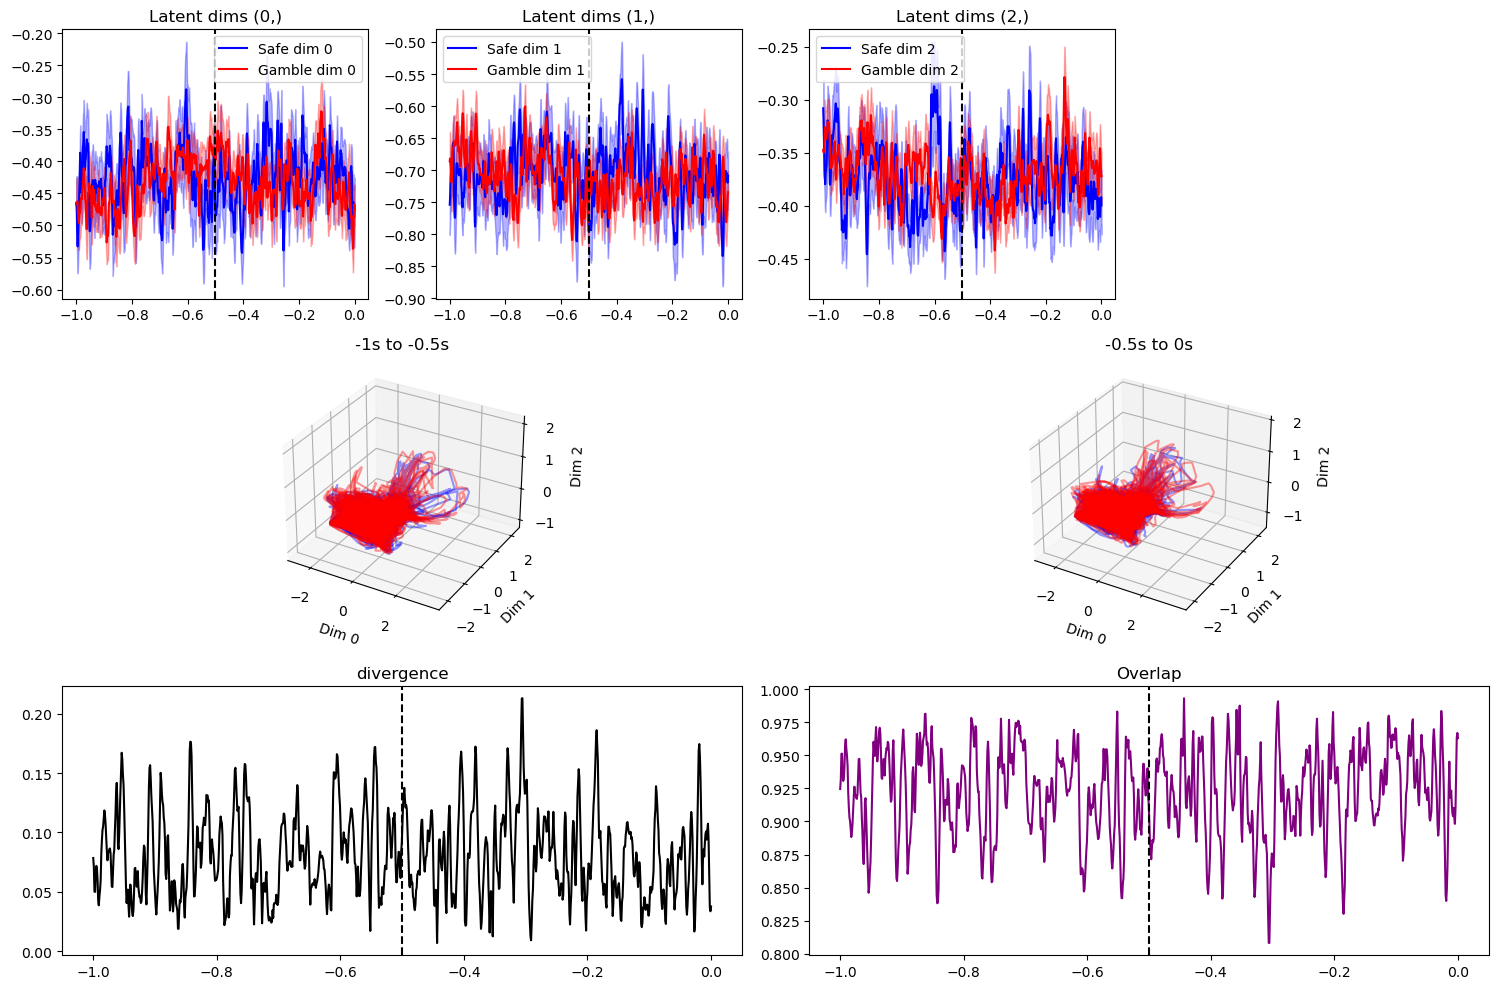

Subject 02: File loaded successfully.


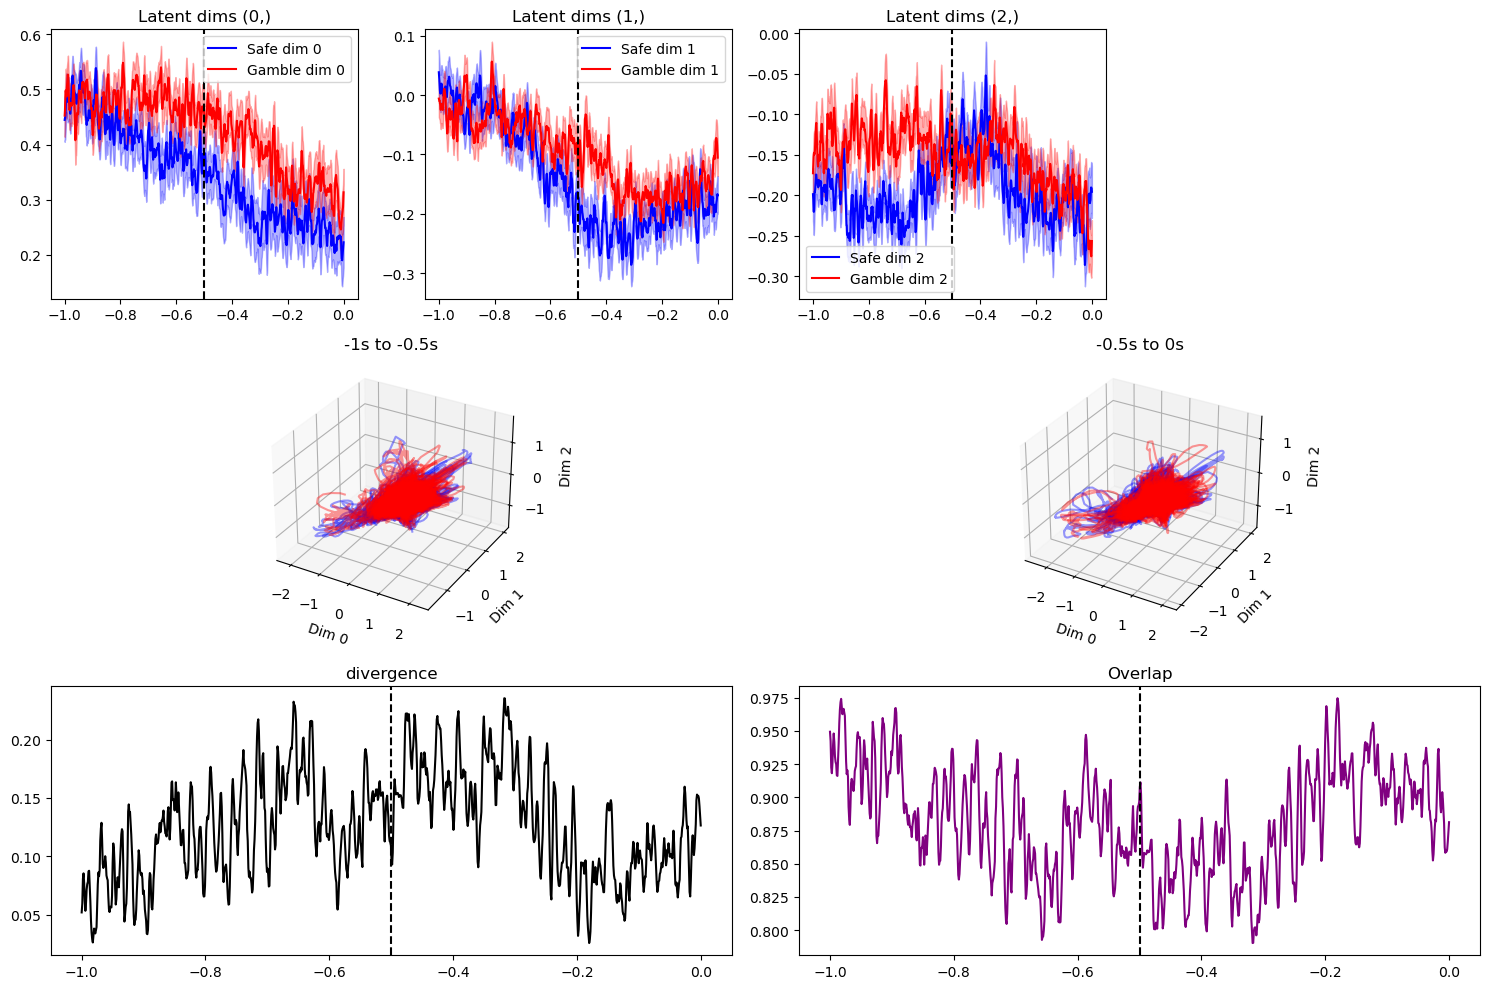

Subject 03: File loaded successfully.


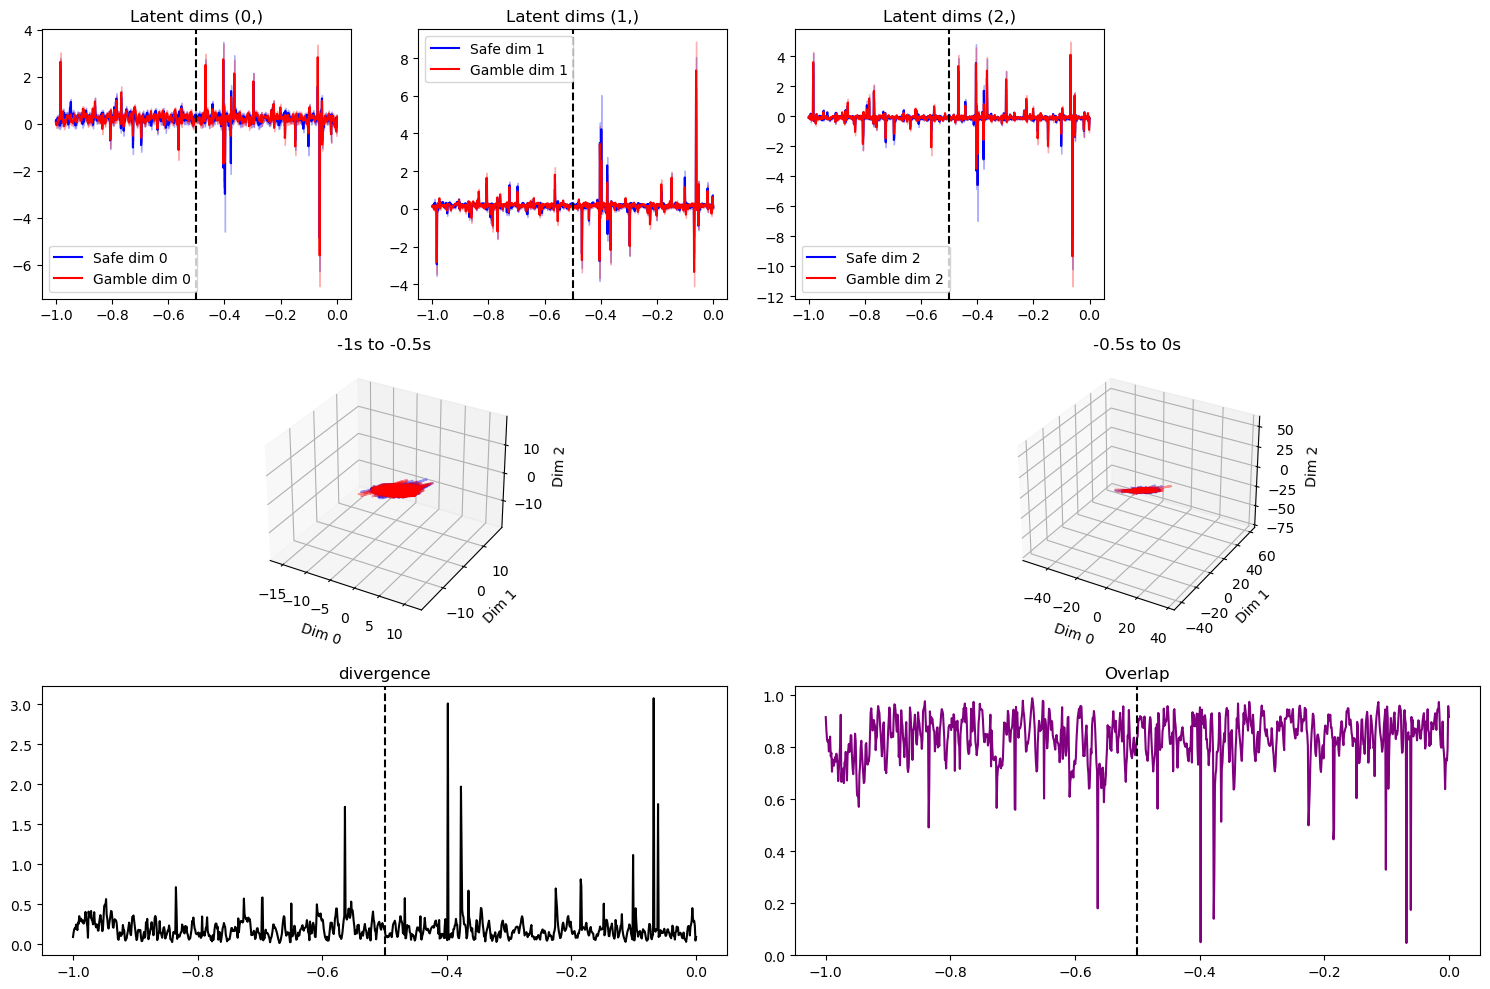

Subject 04: File loaded successfully.


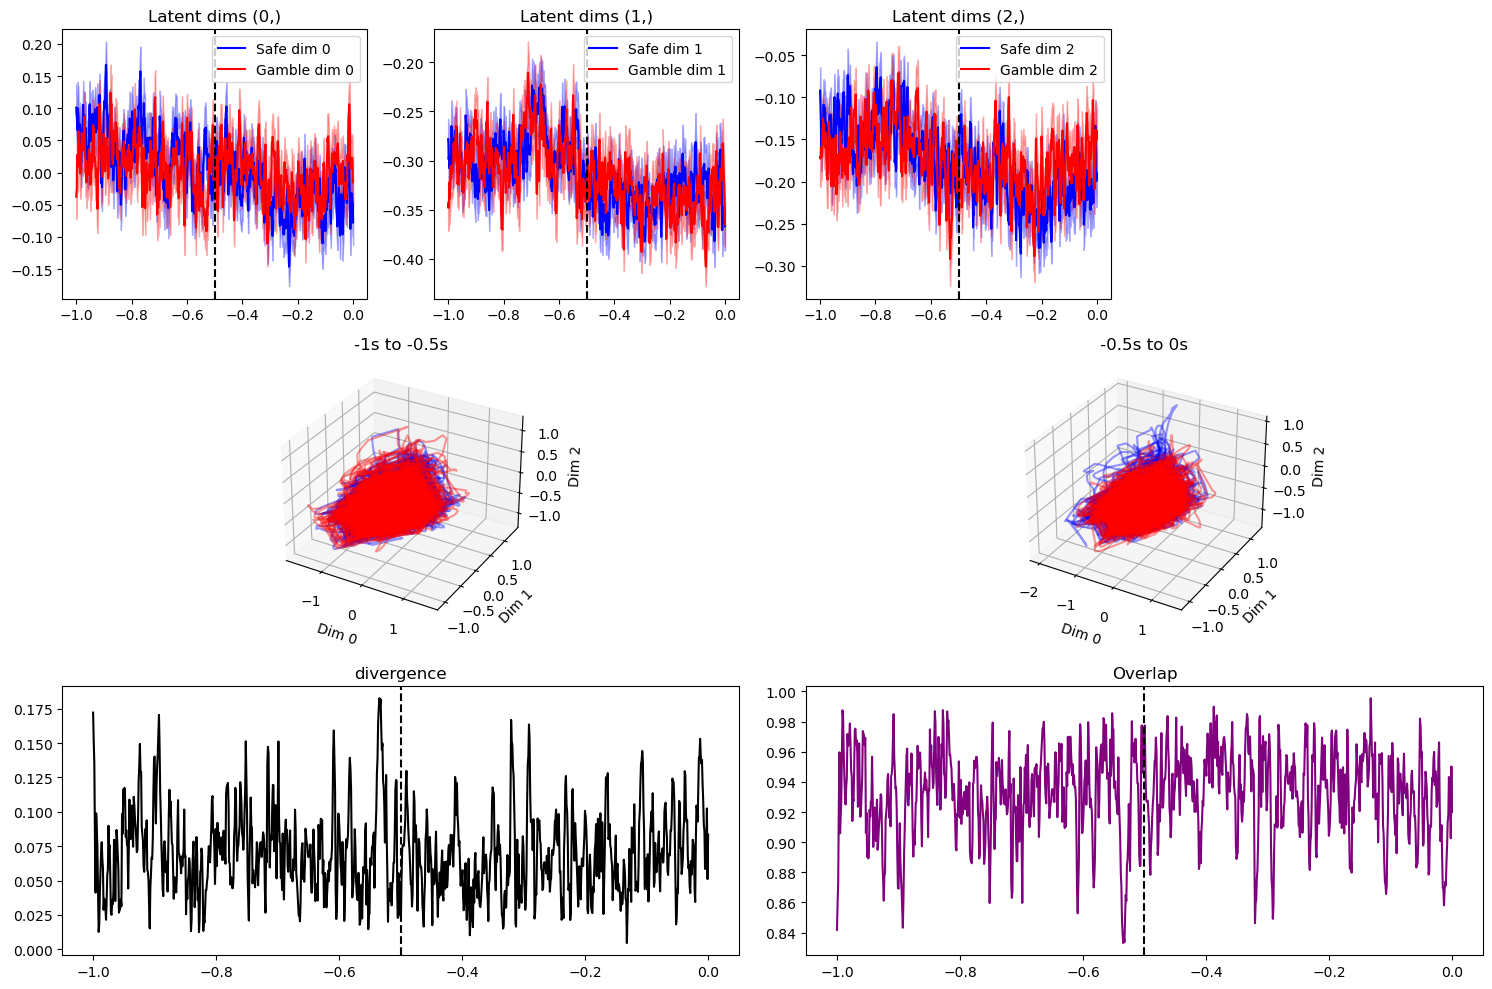

Subject 05: File loaded successfully.


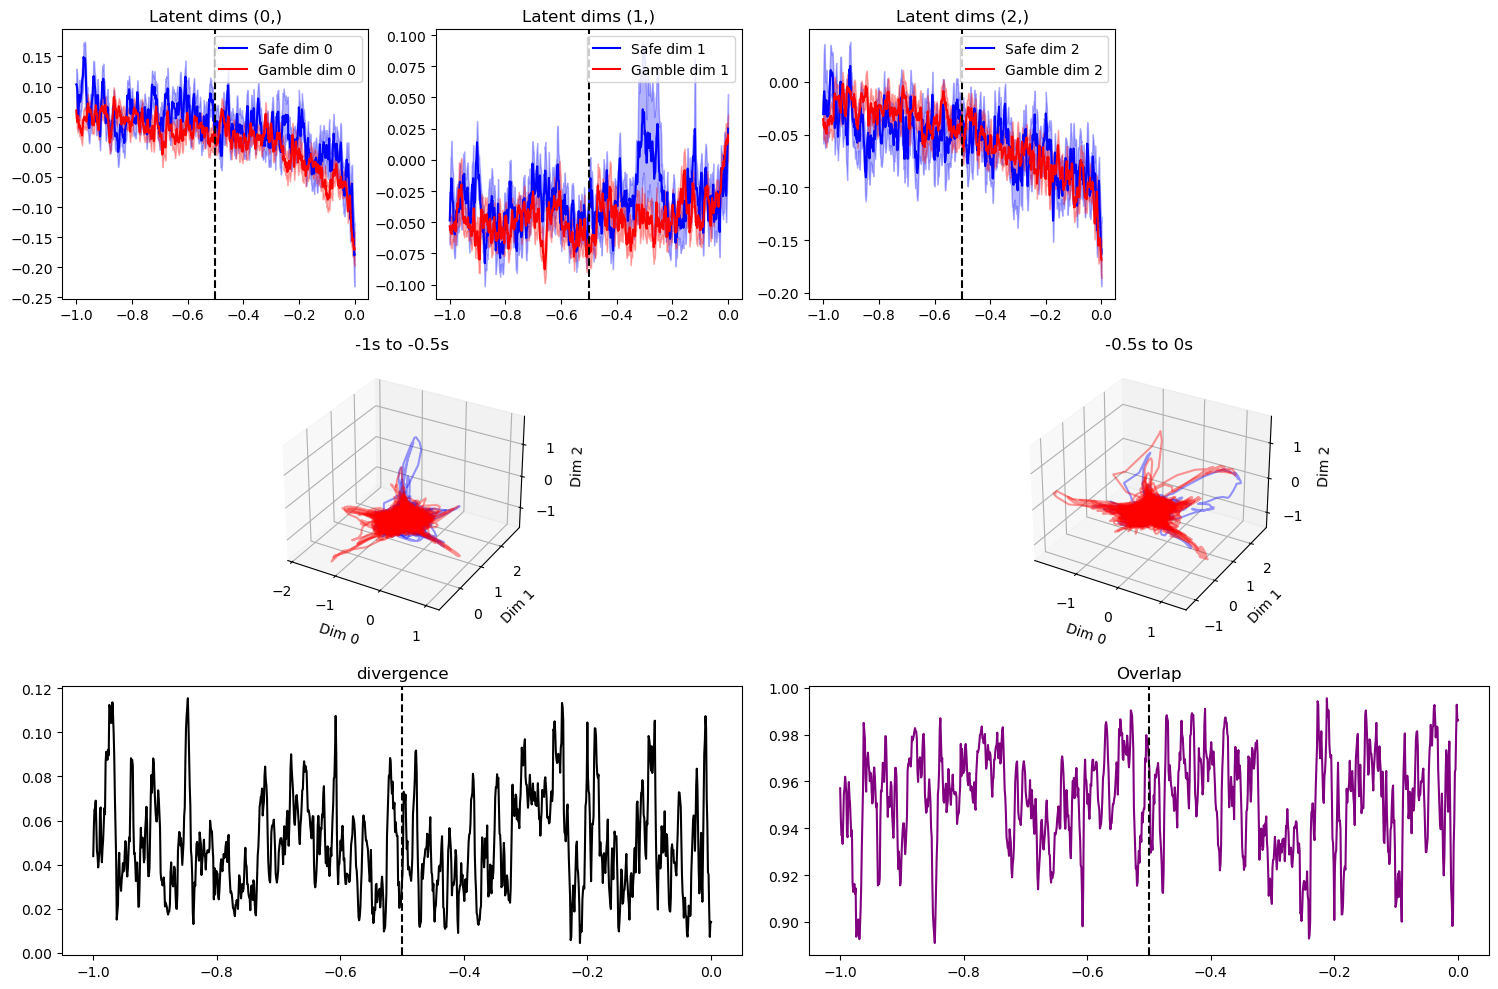

In [ ]:
key = 'x_filter'

for subj in range(1, 6):
    subj_num = f"{subj:02d}" 
    mat_file_path = os.path.join('GTH_data', f'GTH_s{subj_num}_decision_power_struct_nobs.mat')
    f = h5py.File(mat_file_path, 'r')
    
    labelsset = np.array(f["power_struct"]["beh"]["gambles"])
    
    # Extract high gamma power data (time, electrodes, trials)
    gen_data = f["power_struct"]["highgamma"]["powspctrm"]
    highgamma = np.array(gen_data)
    y = np.moveaxis(highgamma, 2, 0)  # now (trials, time, channels)
    
    time_steps = 1000
    time_axis = np.linspace(-1, 0, time_steps)
    
    # Define subject-specific directory and file paths for latent data
    save_dir = os.path.join('results', 'neural', f'subj_{subj_num}')
    g_file_path = os.path.join(save_dir, 'g_latents.pt')
    ng_file_path = os.path.join(save_dir, 'ng_latents.pt')
    all_file_path = os.path.join(save_dir, 'batchwise_latents.pt')
    
    if os.path.exists(g_file_path) and os.path.exists(ng_file_path) and os.path.exists(all_file_path):
        gamble_latents = torch.load(g_file_path)
        no_gamble_latents = torch.load(ng_file_path)
        all_latents = torch.load(all_file_path)
        print(f"Subject {subj_num}: File loaded successfully.")
    else:
        print(f"Subject {subj_num}: File does not exist.")
        continue  # Skip this subject if files are missing
    
    x_gamble = torch.stack(gamble_latents['train'][key], dim=1).squeeze()[:, 2000:3000, :].numpy()
    x_safe   = torch.stack(no_gamble_latents['train'][key], dim=1).squeeze()[:, 2000:3000, :].numpy()
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(3, 4)

    #time series plots
    for i in best_latents[subj]:
        ax = fig.add_subplot(gs[0, i])
        plot_timeseries_with_shade(x_safe, x_gamble, time_axis, ax, dim=i)
    
    #3D state space trajectories split into two time windows
    # -1s to -0.5s
    ax_b1 = fig.add_subplot(gs[1, 0:2], projection='3d')
    plot_state_space_3d(x_safe, x_gamble, ax_b1, slice(0, 500), dims_3d=tuple(best_latents[subj]))
    ax_b1.set_title("-1s to -0.5s")
    
    # -0.5s to 0s
    ax_b2 = fig.add_subplot(gs[1, 2:4], projection='3d')
    plot_state_space_3d(x_safe, x_gamble, ax_b2, slice(500, 1000), dims_3d=tuple(best_latents[subj]))
    ax_b2.set_title("-0.5s to 0s")
    
    #divergence 
    ax_c = fig.add_subplot(gs[2, 0:2])
    divergence = compute_divergence(x_safe, x_gamble, dims=tuple(best_latents[subj]))
    ax_c.plot(time_axis, divergence, color='black')
    ax_c.set_title("divergence")
    ax_c.axvline(x=-0.5, color='k', linestyle='--')
    
    #overlap between safe and gamble trajectories
    ax_d = fig.add_subplot(gs[2, 2:4])
    overlap = compute_overlap(x_safe, x_gamble, dims=tuple(best_latents[subj]))
    ax_d.plot(time_axis, overlap, color='purple')
    ax_d.set_title("Overlap")
    ax_d.axvline(x=-0.5, color='k', linestyle='--')
    
    plt.tight_layout()
    plt.show()


In [ ]:

class MLP(nn.Module):
    #three layer MLP
    def __init__(self, input_size):
        super().__init__() #call nn.Module parent class intializer
        self.fc = nn.Linear(input_size, 2) #flattened input->output layer
    def forward(self, x): 
        return self.fc(x)

for subj in range(1, 21):
    
    subj_num = f"{subj:02}"
    file_path = os.path.join('GTH_data', f'GTH_s{subj_num}_decision_power_struct_nobs.mat')
    f = h5py.File(file_path, 'r')

    labelsset = np.array(f["power_struct"]["beh"]["gambles"]).T.squeeze()
    highgamma = np.array(f["power_struct"]["highgamma"]["powspctrm"])
    y = np.moveaxis(highgamma, 2, 0)  # (trials, time, channels)
    print("dim are:", y.shape)

    seed = 0
    set_seed(seed)

    config = get_default_config()
    config.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    config.model.activation = 'tanh'
    config.train.num_epochs = 200
    config.train.batch_size = 32
    config.lr.init = 0.002
    config.model.supervise_behv = False
    config.seed = seed
    config.model.dim_y = y.shape[2]
    config.model.dim_a = 3
    config.model.dim_x = 3
    config.model.save_dir = f'./results/neural/subj_{subj_num}'
    config.load.ckpt = 'best_loss'

    trainer = TrainerDFINE(config=config)
    save_dir = os.path.join(config.model.save_dir, 'pytorch_cm')
    os.makedirs(save_dir, exist_ok=True)

    all_file_path = os.path.join(config.model.save_dir, 'batchwise_latents.pt')
    if os.path.exists(all_file_path):
        all_latents = torch.load(all_file_path)
        print("File loaded successfully.")
    else:
        print("File does not exist.")
        train_y_zsc, _, _ = z_score_tensor(y, fit=True)
        train_dataset = DFINEDataset(y=train_y_zsc)
        train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
        all_latents = trainer.compute_latents(train_loader=train_loader)
        torch.save(all_latents, all_file_path)

    for key in all_latents['train'].keys():
        if key == 'mask':
            continue

        X = torch.stack(all_latents['train'][key]).squeeze(1)[:, 2000:3001, :].numpy()
        y_labels = labelsset

        n_trials, n_time, n_features = X.shape
        X = X.transpose(0, 2, 1)  # (trials, features, time)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y_labels, dtype=torch.uint8)

        loo = LeaveOneOut()
        all_preds = []
        all_true = []

        for train_idx, test_idx in loo.split(X_tensor):
            model = MLP(input_size=n_time * n_features).to(config.device)
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.0)
            loss_fn = nn.CrossEntropyLoss()

            X_train = X_tensor[train_idx].to(config.device)
            y_train = y_tensor[train_idx].to(config.device)
            X_train = X_train.view(X_train.size(0), -1)

            for epoch in range(20):
                optimizer.zero_grad()
                outputs = model(X_train)
                loss = loss_fn(outputs, y_train)
                loss.backward()
                optimizer.step() #update parameters

            X_test = X_tensor[test_idx].view(1, -1).to(config.device)
            y_test = y_tensor[test_idx].item()
            with torch.no_grad():
                y_pred = model(X_test).argmax(dim=1).item() #get this 

            all_preds.append(y_pred)
            all_true.append(y_test)

        cm = confusion_matrix(all_true, all_preds)
        accuracy = accuracy_score(all_true, all_preds)
        

        save_path = os.path.join(config.model.save_dir, f'{key}_pytorch_results.json')

        accuracy = accuracy_score(all_true, all_preds)
        precision = cm[1,1] / (cm[0,1] + cm[1,1]) if (cm[0,1] + cm[1,1]) > 0 else 0
        recall = cm[1,1] / (cm[1,0] + cm[1,1]) if (cm[1,0] + cm[1,1]) > 0 else 0
        F1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        train_dataset, test_dataset, train_loader, test_loader = train_test_split(y, 0.8)
        total_loss, loss_dict = trainer.model_eval(test_loader)
        model_loss = loss_dict['model_loss'].item()
        
        eval_results = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "F1_score": F1,
            "model_loss": model_loss
        }
        with open(save_path, "w") as json_file:
            json.dump(eval_results, json_file, indent=4)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Gamble", "Gamble"])
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix for {key}")
        plt.text(1.7, 1.75, f'F1: {F1:.3f}\nAccuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}', fontsize=6)
        plt.savefig(os.path.join(save_dir, f"{key}_pytorch_cm.png"))
        plt.close()

04/05/2025 05:34:42 PM - DFINE Logger - WARNING - Optimizer and LR scheduler can be loaded only in resume_train mode, else they are re-initialized
04/05/2025 05:34:42 PM - DFINE Logger - INFO - Loading model from: ./results/neural/subj_01\ckpts\best_loss_ckpt.pth...
04/05/2025 05:34:42 PM - DFINE Logger - INFO - Checkpoint succesfully loaded from ./results/neural/subj_01\ckpts\best_loss_ckpt.pth!


dim are: (180, 5001, 57)
TrainerDFINE loaded from: C:\Users\angel\Desktop\Code\torchDFINE\trainers\TrainerDFINE.py
File loaded successfully.


04/05/2025 05:35:55 PM - DFINE Logger - WARNING - Optimizer and LR scheduler can be loaded only in resume_train mode, else they are re-initialized
04/05/2025 05:35:55 PM - DFINE Logger - INFO - Loading model from: ./results/neural/subj_02\ckpts\best_loss_ckpt.pth...
04/05/2025 05:35:55 PM - DFINE Logger - INFO - Checkpoint succesfully loaded from ./results/neural/subj_02\ckpts\best_loss_ckpt.pth!


dim are: (188, 5001, 60)
TrainerDFINE loaded from: C:\Users\angel\Desktop\Code\torchDFINE\trainers\TrainerDFINE.py
File loaded successfully.


04/05/2025 05:37:31 PM - DFINE Logger - WARNING - Optimizer and LR scheduler can be loaded only in resume_train mode, else they are re-initialized
04/05/2025 05:37:31 PM - DFINE Logger - INFO - Loading model from: ./results/neural/subj_03\ckpts\best_loss_ckpt.pth...
04/05/2025 05:37:31 PM - DFINE Logger - INFO - Checkpoint succesfully loaded from ./results/neural/subj_03\ckpts\best_loss_ckpt.pth!


dim are: (177, 5001, 250)
TrainerDFINE loaded from: C:\Users\angel\Desktop\Code\torchDFINE\trainers\TrainerDFINE.py
File loaded successfully.


04/05/2025 05:38:49 PM - DFINE Logger - WARNING - Optimizer and LR scheduler can be loaded only in resume_train mode, else they are re-initialized
04/05/2025 05:38:49 PM - DFINE Logger - INFO - Loading model from: ./results/neural/subj_04\ckpts\best_loss_ckpt.pth...
04/05/2025 05:38:49 PM - DFINE Logger - INFO - Checkpoint succesfully loaded from ./results/neural/subj_04\ckpts\best_loss_ckpt.pth!


dim are: (194, 5001, 101)
TrainerDFINE loaded from: C:\Users\angel\Desktop\Code\torchDFINE\trainers\TrainerDFINE.py
File loaded successfully.


04/05/2025 05:40:19 PM - DFINE Logger - WARNING - Optimizer and LR scheduler can be loaded only in resume_train mode, else they are re-initialized
04/05/2025 05:40:19 PM - DFINE Logger - INFO - Loading model from: ./results/neural/subj_05\ckpts\best_loss_ckpt.pth...
04/05/2025 05:40:19 PM - DFINE Logger - INFO - Checkpoint succesfully loaded from ./results/neural/subj_05\ckpts\best_loss_ckpt.pth!


dim are: (176, 5001, 143)
TrainerDFINE loaded from: C:\Users\angel\Desktop\Code\torchDFINE\trainers\TrainerDFINE.py
File loaded successfully.


04/05/2025 05:41:38 PM - DFINE Logger - WARNING - Optimizer and LR scheduler can be loaded only in resume_train mode, else they are re-initialized
04/05/2025 05:41:38 PM - DFINE Logger - INFO - Loading model from: ./results/neural/subj_06\ckpts\best_loss_ckpt.pth...
04/05/2025 05:41:38 PM - DFINE Logger - INFO - Checkpoint succesfully loaded from ./results/neural/subj_06\ckpts\best_loss_ckpt.pth!


dim are: (187, 5001, 96)
TrainerDFINE loaded from: C:\Users\angel\Desktop\Code\torchDFINE\trainers\TrainerDFINE.py
File loaded successfully.


04/05/2025 05:42:59 PM - DFINE Logger - WARNING - Optimizer and LR scheduler can be loaded only in resume_train mode, else they are re-initialized
04/05/2025 05:42:59 PM - DFINE Logger - INFO - Loading model from: ./results/neural/subj_07\ckpts\best_loss_ckpt.pth...
04/05/2025 05:42:59 PM - DFINE Logger - INFO - Checkpoint succesfully loaded from ./results/neural/subj_07\ckpts\best_loss_ckpt.pth!


dim are: (181, 5001, 91)
TrainerDFINE loaded from: C:\Users\angel\Desktop\Code\torchDFINE\trainers\TrainerDFINE.py
File loaded successfully.


04/05/2025 05:44:24 PM - DFINE Logger - WARNING - Optimizer and LR scheduler can be loaded only in resume_train mode, else they are re-initialized
04/05/2025 05:44:24 PM - DFINE Logger - INFO - Loading model from: ./results/neural/subj_08\ckpts\best_loss_ckpt.pth...
04/05/2025 05:44:24 PM - DFINE Logger - INFO - Checkpoint succesfully loaded from ./results/neural/subj_08\ckpts\best_loss_ckpt.pth!


dim are: (196, 5001, 108)
TrainerDFINE loaded from: C:\Users\angel\Desktop\Code\torchDFINE\trainers\TrainerDFINE.py
File loaded successfully.


KeyboardInterrupt: 

In [ ]:
import os
import json

for subj in range(1, 21):
    subj_num = f"{subj:02}" 
    f = h5py.File('GTH_data\GTH_s' + str(subj_num) + '_decision_power_struct_nobs.mat', 'r')
    dataset = list(f["power_struct"]["highgamma"]["powspctrm"])
    labelsset = np.array(f["power_struct"]["beh"]["gambles"])
    
    gen_data = f["power_struct"]["highgamma"]["powspctrm"]
    highgamma = np.array(gen_data) # (time, electrodes, trials)
    y= np.moveaxis(highgamma,2,0) # (trials, time, channels)
    print("dim are: " , y.shape) #(num_seq, num_steps, dim_y)

    labelsset = labelsset.T
    behv_mask = torch.tensor(labelsset)
    behv_mask = behv_mask.squeeze() 

    gamble = y[behv_mask == 1]
    no_gamble = y[behv_mask == 0] 
    seed=0
    set_seed(seed)

    config = get_default_config()
    config.device = 'cuda'
    config.model.activation ='tanh'
    config.train.num_epochs = 200
    config.train.batch_size = 32
    config.lr.init = 0.002
    config.model.supervise_behv = False
    config.seed = seed
    config.model.dim_y = y.shape[2]    
    config.model.dim_a = 3    #manifold latent factors
    config.model.dim_x = 3     #dynamic latent factors (should be same as dim a)
    config.model.save_dir = f'./results/neural/subj_{subj_num}'
    
    config.load.ckpt = 'best_loss'
    trainer = TrainerDFINE(config=config)
    
    predictions = {
        "x_pred": [],
        "x_filter": [],
        "x_smooth": [],
        "a_hat": [],
        "a_pred": [],
        "a_filter": [],
        "a_smooth": [],
    }
    
    g_file_path = os.path.join(config.model.save_dir, 'g_latents.pt')
    ng_file_path = os.path.join(config.model.save_dir, 'ng_latents.pt')
    all_file_path = os.path.join(config.model.save_dir, 'batchwise_latents.pt')
    if os.path.exists(g_file_path) and  os.path.exists(ng_file_path) and os.path.exists(all_file_path):
        gamble_latents = torch.load(g_file_path)
        no_gamble_latents = torch.load(ng_file_path)
        all_latents = torch.load(all_file_path)
        print("File loaded successfully.")
    else:
        print("File does not exist.")
        gamble_dataset,  _,gamble_loader, _ = train_test_split(gamble, 1, batch_size = 1)
        no_gamble_dataset,_, no_gamble_loader ,_ = train_test_split(no_gamble, 1, batch_size = 1)

        g_train_loader = DataLoader(gamble_dataset, batch_size =  1, shuffle= False)
        gamble_latents = trainer.compute_latents(train_loader=gamble_loader)

        no_train_loader = DataLoader(no_gamble_dataset, batch_size =  1, shuffle = False) 
        no_gamble_latents = trainer.compute_latents(train_loader= no_gamble_loader)

        train_y_zsc, mean_y, std_y = z_score_tensor(y, fit=True)
        train_dataset = DFINEDataset(y=train_y_zsc)
        train_loader = DataLoader(train_dataset, batch_size = 1, shuffle=False)
        all_latents = trainer.compute_latents(train_loader= train_loader)
        torch.save(gamble_latents, g_file_path)
        torch.save(no_gamble_latents, ng_file_path)
        torch.save(all_latents, all_file_path)

    save_dir = os.path.join(config.model.save_dir, 'confusion_matrices')
    os.makedirs(save_dir, exist_ok=True)


    confusion_matrices = {}
    num_g_trials = np.sum(labelsset)
    num_ng_trials = y.shape[0]-num_g_trials
    for key in gamble_latents['train'].keys():
        if key == 'mask':
            continue
        total_g = torch.stack(gamble_latents['train'][key], dim=0).squeeze().sum(dim=0, keepdim = True).squeeze()[2000:3001]
        total_ng = torch.stack(no_gamble_latents['train'][key], dim=0).squeeze().sum(dim=0, keepdim = True).squeeze()[2000:3001]

        avg_latent_factor_plot(total_g/num_g_trials, config.model.save_dir, feat_name=key)
        avg_latent_factor_plot(total_ng/num_ng_trials, config.model.save_dir, prefix="no gamble", feat_name=key)
        
        for trial in range(0,y.shape[0]):
            if labelsset[trial]:
                gamble_avg = ((total_g - all_latents['train'][key][trial].squeeze()[2000:3001]) / (num_g_trials-1))
                no_gamble_avg = total_ng/(num_ng_trials)
                
            else:
                gamble_avg = total_g/(num_g_trials)
                no_gamble_avg = ((total_ng - all_latents['train'][key][trial].squeeze()[2000:3001]) /( num_ng_trials-1))

            test_data = all_latents['train'][key][trial].squeeze()[2000:3001]

            g_distances = findEuclidianDist(gamble_avg, test_data,1)
            ng_distances =  findEuclidianDist(no_gamble_avg, test_data,1)

            predictions[key].append(1 if ng_distances > g_distances else 0)

        cm = confusion_matrix(labelsset, predictions[key])
        save_path = os.path.join(config.model.save_dir, f'{key}_eval_results.json')
    
        if os.path.exists(save_path):
            with open(save_path, "r") as json_file:
                eval_results = json.load(json_file)
                accuracy = eval_results['accuracy']
                precision = eval_results['precision']
                recall = eval_results['recall']
                F1 = eval_results['F1_score']
                model_loss = eval_results['model_loss']
            
        else:
            print("File does not exist.")
            tn, fp, fn, tp = cm.ravel()
            accuracy = (tn + tp) / np.sum(cm) 
            precision = tp / (tp + fp) 
            recall = tp / (tp + fn)
            F1 = 2 * (precision * recall) / (precision + recall)
    
            train_dataset, test_dataset, train_loader, test_loader = train_test_split(y, 0.8)
            total_loss, loss_dict = trainer.model_eval(test_loader)
            model_loss = loss_dict['model_loss'].item()
            
            eval_results = {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "F1_score": F1,
                "model_loss": model_loss
            }
            
            # Ensure directory exists and save JSON
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            
            with open(save_path, "w") as json_file:
                json.dump(eval_results, json_file, indent=4)
                
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Gamble", "Gamble"])
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix for {key}")
        plt.text(1.7, 1.75, f'F1 score: {F1} \n Accuracy: {accuracy} \n Precision: {precision} \n Recall: {recall} \n model loss: {model_loss}', fontsize=5)
        plt.savefig(os.path.join(save_dir, f"{key}_confusion_matrix.png"))
        plt.close()



In [ ]:
import os
import json

for subj in range(1, 21):
    subj_num = f"{subj:02}" 
    f = h5py.File('GTH_data\GTH_s' + str(subj_num) + '_decision_power_struct_nobs.mat', 'r')
    dataset = list(f["power_struct"]["highgamma"]["powspctrm"])
    labelsset = np.array(f["power_struct"]["beh"]["gambles"])
    
    gen_data = f["power_struct"]["highgamma"]["powspctrm"]
    highgamma = np.array(gen_data) # (time, electrodes, trials)
    y= np.moveaxis(highgamma,2,0) # (trials, time, channels)
    print("dim are: " , y.shape) #(num_seq, num_steps, dim_y)

    labelsset = labelsset.T
    behv_mask = torch.tensor(labelsset)
    behv_mask = behv_mask.squeeze() 

    gamble = y[behv_mask == 1]
    no_gamble = y[behv_mask == 0] 
    seed=0
    set_seed(seed)

    config = get_default_config()
    config.device = 'cuda'
    config.model.activation ='tanh'
    config.train.num_epochs = 200
    config.train.batch_size = 32
    config.lr.init = 0.002
    config.model.supervise_behv = False
    config.seed = seed
    config.model.dim_y = y.shape[2]    
    config.model.dim_a = 3    #manifold latent factors
    config.model.dim_x = 3     #dynamic latent factors (should be same as dim a)
    config.model.save_dir = f'./results/neural/subj_{subj_num}'
    
    config.load.ckpt = 'best_loss'
    trainer = TrainerDFINE(config=config)
    
    predictions = {
        "x_pred": [],
        "x_filter": [],
        "x_smooth": [],
        "a_hat": [],
        "a_pred": [],
        "a_filter": [],
        "a_smooth": [],
    }
    
    g_file_path = os.path.join(config.model.save_dir, 'g_latents.pt')
    ng_file_path = os.path.join(config.model.save_dir, 'ng_latents.pt')
    all_file_path = os.path.join(config.model.save_dir, 'batchwise_latents.pt')
    if os.path.exists(g_file_path) and  os.path.exists(ng_file_path) and os.path.exists(all_file_path):
        gamble_latents = torch.load(g_file_path)
        no_gamble_latents = torch.load(ng_file_path)
        all_latents = torch.load(all_file_path)
        print("File loaded successfully.")
    else:
        print("File does not exist.")
        gamble_dataset,  _,gamble_loader, _ = train_test_split(gamble, 1, batch_size = 1)
        no_gamble_dataset,_, no_gamble_loader ,_ = train_test_split(no_gamble, 1, batch_size = 1)

        g_train_loader = DataLoader(gamble_dataset, batch_size =  1, shuffle= False)
        gamble_latents = trainer.compute_latents(train_loader=gamble_loader)

        no_train_loader = DataLoader(no_gamble_dataset, batch_size =  1, shuffle = False) 
        no_gamble_latents = trainer.compute_latents(train_loader= no_gamble_loader)

        train_y_zsc, mean_y, std_y = z_score_tensor(y, fit=True)
        train_dataset = DFINEDataset(y=train_y_zsc)
        train_loader = DataLoader(train_dataset, batch_size = 1, shuffle=False)
        all_latents = trainer.compute_latents(train_loader= train_loader)
        torch.save(gamble_latents, g_file_path)
        torch.save(no_gamble_latents, ng_file_path)
        torch.save(all_latents, all_file_path)

    save_dir = os.path.join(config.model.save_dir, 'confusion_matrices')
    os.makedirs(save_dir, exist_ok=True)


    confusion_matrices = {}
    num_g_trials = np.sum(labelsset)
    num_ng_trials = y.shape[0]-num_g_trials
    for key in gamble_latents['train'].keys():
        if key == 'mask':
            continue
        total_g = torch.stack(gamble_latents['train'][key], dim=0).squeeze().sum(dim=0, keepdim = True).squeeze()[2000:3001]
        total_ng = torch.stack(no_gamble_latents['train'][key], dim=0).squeeze().sum(dim=0, keepdim = True).squeeze()[2000:3001]

        avg_latent_factor_plot(total_g/num_g_trials, config.model.save_dir, feat_name=key)
        avg_latent_factor_plot(total_ng/num_ng_trials, config.model.save_dir, prefix="no gamble", feat_name=key)
        for trial in range(0,y.shape[0]):
            if labelsset[trial]:
                gamble_avg = ((total_g - all_latents['train'][key][trial].squeeze()[2000:3001]) / (num_g_trials-1))
                no_gamble_avg = total_ng/(num_ng_trials)
                
            else:
                gamble_avg = total_g/(num_g_trials)
                no_gamble_avg = ((total_ng - all_latents['train'][key][trial].squeeze()[2000:3001]) /( num_ng_trials-1))

            test_data = all_latents['train'][key][trial].squeeze()[2000:3001]

            g_distances = findEuclidianDist(gamble_avg, test_data,1)
            ng_distances =  findEuclidianDist(no_gamble_avg, test_data,1)

            predictions[key].append(1 if ng_distances > g_distances else 0)

        cm = confusion_matrix(labelsset, predictions[key])
        save_path = os.path.join(config.model.save_dir, f'{key}_eval_results.json')
    
        if os.path.exists(save_path):
            with open(save_path, "r") as json_file:
                eval_results = json.load(json_file)
                accuracy = eval_results['accuracy']
                precision = eval_results['precision']
                recall = eval_results['recall']
                F1 = eval_results['F1_score']
                model_loss = eval_results['model_loss']
            
        else:
            print("File does not exist.")
            tn, fp, fn, tp = cm.ravel()
            accuracy = (tn + tp) / np.sum(cm) 
            precision = tp / (tp + fp) 
            recall = tp / (tp + fn)
            F1 = 2 * (precision * recall) / (precision + recall)
    
            train_dataset, test_dataset, train_loader, test_loader = train_test_split(y, 0.8)
            total_loss, loss_dict = trainer.model_eval(test_loader)
            model_loss = loss_dict['model_loss'].item()
            
            eval_results = {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "F1_score": F1,
                "model_loss": model_loss
            }
            
            # Ensure directory exists and save JSON
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            
            with open(save_path, "w") as json_file:
                json.dump(eval_results, json_file, indent=4)
                
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Gamble", "Gamble"])
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix for {key}")
        plt.text(1.7, 1.75, f'F1 score: {F1} \n Accuracy: {accuracy} \n Precision: {precision} \n Recall: {recall} \n model loss: {model_loss}', fontsize=5)
        plt.savefig(os.path.join(save_dir, f"{key}_confusion_matrix.png"))
        plt.close()



In [16]:
import os

# Define the parameter grid
param_grid = {
    "scale_l2": [0.0001, 0.001],
    "latent_factors" :[15,30]
}

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# Store the best configuration
best_params = None
best_score = float("inf")


for subj in range(1, 21):
    subj_num = f"{subj:02}" 
    f = h5py.File('GTH_data\GTH_s' + str(subj_num) + '_decision_power_struct_nobs.mat', 'r')
    dataset = list(f["power_struct"]["highgamma"]["powspctrm"])
    labelsset = np.array(f["power_struct"]["beh"]["gambles"])
    
    gen_data = f["power_struct"]["highgamma"]["powspctrm"]
    highgamma = np.array(gen_data) # (time, electrodes, trials)
    y= np.moveaxis(highgamma,2,0) # (trials, time, channels)
    print("dim are: " , y.shape) #(num_seq, num_steps, dim_y)

    labelsset = labelsset.T
    behv_mask = torch.tensor(labelsset)
    behv_mask = behv_mask.squeeze() 

    gamble = y[behv_mask == 1]
    no_gamble = y[behv_mask == 0] 
    seed=0
    set_seed(seed)
    for params in param_combinations:
        # Map parameters to config
        param_dict = dict(zip(param_names, params))
        latent_factors = param_dict["latent_factors"]
        scale_l2 = param_dict["scale_l2"]
        config = get_default_config()
        config.device = 'cuda'
        config.model.activation ='tanh'
        config.train.num_epochs = 40
        config.train.batch_size = 4
        config.lr.init = 0.01
        config.model.supervise_behv = False
        config.seed = seed
        config.model.dim_y = y.shape[2]    
        config.model.dim_a = latent_factors     #manifold latent factors
        config.model.dim_x = latent_factors     #dynamic latent factors (should be same as dim a)
        config.loss.scale_l2 = scale_l2
        config.model.save_dir = f'./results/neural/subj_{subj_num}_l2_{scale_l2}_nlatent_{latent_factors}'
        
        config.load.ckpt = 'best_loss'
        trainer = TrainerDFINE(config=config)
        
        predictions = {
            "x_pred": [],
            "x_filter": [],
            "x_smooth": [],
            "a_hat": [],
            "a_pred": [],
            "a_filter": [],
            "a_smooth": [],
        }
        
        g_file_path = os.path.join(config.model.save_dir, 'g_latents.pt')
        ng_file_path = os.path.join(config.model.save_dir, 'ng_latents.pt')
        all_file_path = os.path.join(config.model.save_dir, 'batchwise_latents.pt')
        if os.path.exists(g_file_path) and  os.path.exists(ng_file_path) and os.path.exists(all_file_path):
            gamble_latents = torch.load(g_file_path)
            no_gamble_latents = torch.load(ng_file_path)
            all_latents = torch.load(all_file_path)
            print("File loaded successfully.")
        else:
            print("File does not exist.")
            gamble_dataset,  _,gamble_loader, _ = train_test_split(gamble, 1, batch_size = 1)
            no_gamble_dataset,_, no_gamble_loader ,_ = train_test_split(no_gamble, 1, batch_size = 1)
    
            g_train_loader = DataLoader(gamble_dataset, batch_size =  1, shuffle= False)
            gamble_latents = trainer.compute_latents(train_loader=gamble_loader)
    
            no_train_loader = DataLoader(no_gamble_dataset, batch_size =  1, shuffle = False) 
            no_gamble_latents = trainer.compute_latents(train_loader= no_gamble_loader)
    
            train_y_zsc, mean_y, std_y = z_score_tensor(y, fit=True)
            train_dataset = DFINEDataset(y=train_y_zsc)
            train_loader = DataLoader(train_dataset, batch_size = 1, shuffle=False)
            all_latents = trainer.compute_latents(train_loader= train_loader)
            torch.save(gamble_latents, g_file_path)
            torch.save(no_gamble_latents, ng_file_path)
            torch.save(all_latents, all_file_path)
    
        save_dir = os.path.join(config.model.save_dir, 'confusion_matrices')
        os.makedirs(save_dir, exist_ok=True)
    
    
        confusion_matrices = {}
        num_g_trials = np.sum(labelsset)
        num_ng_trials = y.shape[0]-num_g_trials
        for key in gamble_latents['train'].keys():
            if key == 'mask':
                continue
            total_g = torch.stack(gamble_latents['train'][key], dim=0).squeeze().sum(dim=0, keepdim = True).squeeze()[2000:3001]
            total_ng = torch.stack(no_gamble_latents['train'][key], dim=0).squeeze().sum(dim=0, keepdim = True).squeeze()[2000:3001]
    
            avg_latent_factor_plot(total_g/num_g_trials, config.model.save_dir, feat_name=key)
            avg_latent_factor_plot(total_ng/num_ng_trials, config.model.save_dir, prefix="no gamble", feat_name=key)
            for trial in range(0,y.shape[0]):
                if labelsset[trial]:
                    gamble_avg = ((total_g - all_latents['train'][key][trial].squeeze()[2000:3001]) / (num_g_trials-1))
                    no_gamble_avg = total_ng/(num_ng_trials)
                    
                else:
                    gamble_avg = total_g/(num_g_trials)
                    no_gamble_avg = ((total_ng - all_latents['train'][key][trial].squeeze()[2000:3001]) /( num_ng_trials-1))
    
                test_data = all_latents['train'][key][trial].squeeze()[2000:3001]
    
                g_distances = findEuclidianDist(gamble_avg, test_data,1)
                ng_distances =  findEuclidianDist(no_gamble_avg, test_data,1)
    
                predictions[key].append(1 if ng_distances > g_distances else 0)
    
            cm = confusion_matrix(labelsset, predictions[key])
        save_path = os.path.join(config.model.save_dir, f'{key}_eval_results.json')

        if os.path.exists(save_path):
            with open(save_path, "r") as json_file:
                eval_results = json.load(json_file)
                accuracy = eval_results['accuracy']
                precision = eval_results['precision']
                recall = eval_results['recall']
                F1 = eval_results['F1_score']
                model_loss = eval_results['model_loss']
            
        else:
            print("File does not exist.")
            tn, fp, fn, tp = cm.ravel()
            accuracy = (tn + tp) / np.sum(cm) 
            precision = tp / (tp + fp) 
            recall = tp / (tp + fn)
            F1 = 2 * (precision * recall) / (precision + recall)
    
            train_dataset, test_dataset, train_loader, test_loader = train_test_split(y, 0.8)
            total_loss, loss_dict = trainer.model_eval(test_loader)
            model_loss = loss_dict['model_loss'].item()
            
            eval_results = {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "F1_score": F1,
                "model_loss": model_loss
            }
            
            # Ensure directory exists and save JSON
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            
            with open(save_path, "w") as json_file:
                json.dump(eval_results, json_file, indent=4)
                
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Gamble", "Gamble"])
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix for {key}")
        plt.text(1.7, 1.75, f'F1 score: {F1} \n Accuracy: {accuracy} \n Precision: {precision} \n Recall: {recall} \n model loss: {model_loss}', fontsize=5)
        plt.savefig(os.path.join(save_dir, f"{key}_confusion_matrix.png"))
        plt.close()

<>:19: SyntaxWarning: invalid escape sequence '\G'
<>:19: SyntaxWarning: invalid escape sequence '\G'
C:\Users\angel\AppData\Local\Temp\ipykernel_27688\671918649.py:19: SyntaxWarning: invalid escape sequence '\G'
  f = h5py.File('GTH_data\GTH_s' + str(subj_num) + '_decision_power_struct_nobs.mat', 'r')


NameError: name 'h5py' is not defined

Data saved to ./results/neural\best_params.csv
Table image saved as ./results/neural\best_params.png
Key occurrences in best-performing models:
x_pred      6
a_pred      5
x_filter    4
a_smooth    4
a_hat       1
Name: Key, dtype: int64

Most frequently occurring best key: x_pred (occurs 6 times)
Table image saved as ./results/neural\best_key_per_subject_highlighted.png


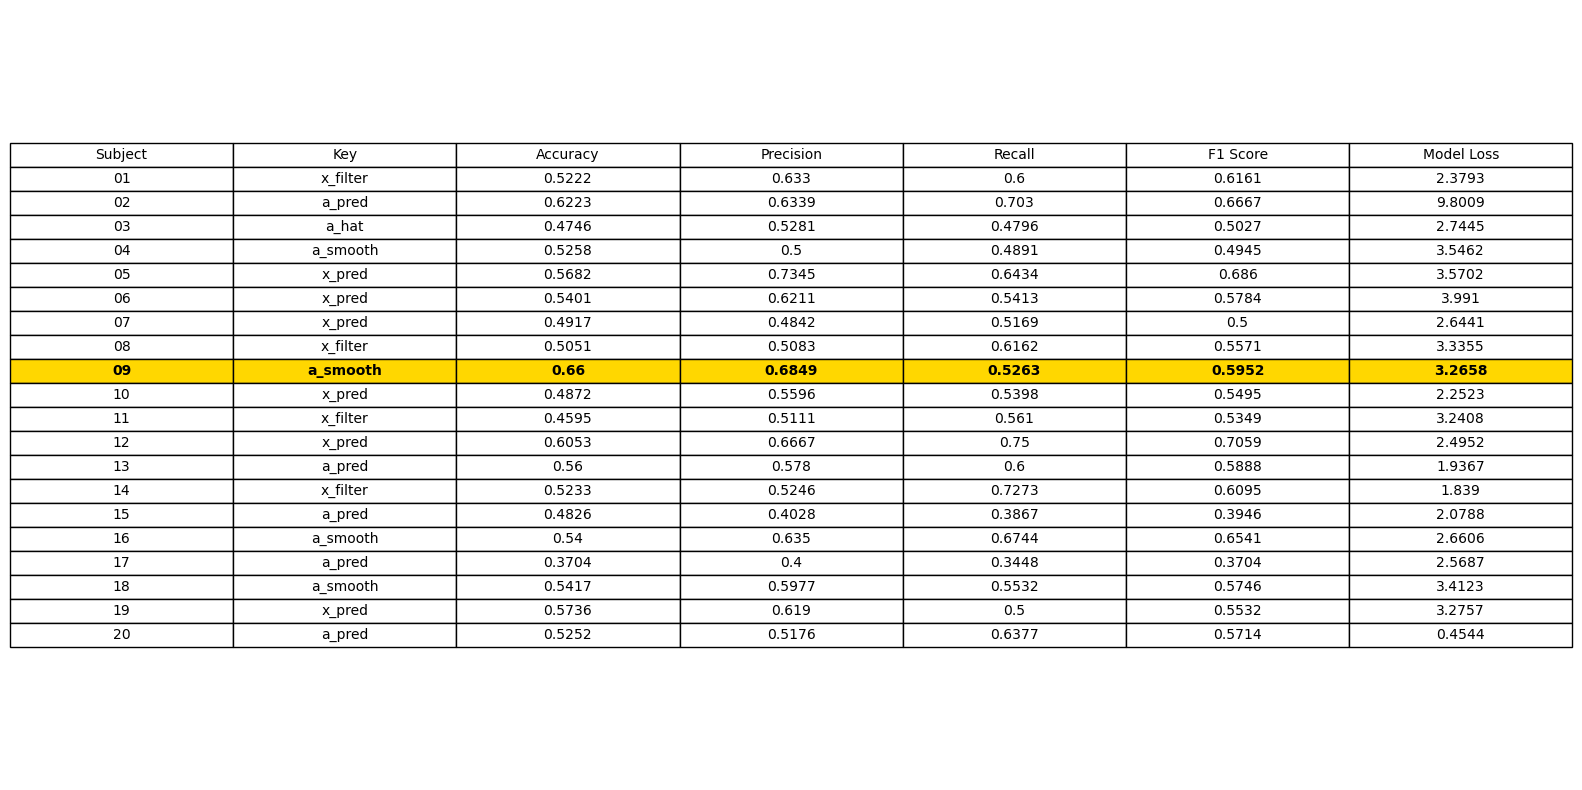

In [10]:

import os
import json
import pandas as pd
import matplotlib.pyplot as plt

keys = ["x_filter", "x_smooth", "x_pred", "a_smooth", "a_filter", "a_hat", "a_pred"]
subjects = range(1, 21)

data = []

for subj in subjects:
    for key in keys:
        subj_num = f"{subj:02}" 
        save_path = os.path.join(f'./results/neural/subj_{subj_num}', f'{key}_eval_results.json')
        
        if os.path.exists(save_path):
            with open(save_path, "r") as json_file:           
                eval_results = json.load(json_file)

                # Append extracted information
                data.append({
                    "Subject": subj_num,
                    "Key": key,
                    "Accuracy": eval_results["accuracy"],
                    "Precision": eval_results["precision"],
                    "Recall": eval_results["recall"],
                    "F1 Score": eval_results["F1_score"],
                    "Model Loss": eval_results["model_loss"]
                })

        else:
            print(f'subj {subj_num} key {key} not found')

df = pd.DataFrame(data)

df_cleaned = df.dropna(subset=["Accuracy"])  # Remove rows where Accuracy is NaN
best_df = df_cleaned.loc[df_cleaned.groupby("Subject")["Accuracy"].idxmax()]

best_df = best_df.round({"Accuracy": 4, "Precision": 4, "Recall": 4, "F1 Score": 4, "Model Loss": 4})

output_dir = "./results/neural"
os.makedirs(output_dir, exist_ok=True)

csv_filename = os.path.join(output_dir, "best_params.csv")
best_df.to_csv(csv_filename, index=False)
print(f"Data saved to {csv_filename}")

fig, ax = plt.subplots(figsize=(14, len(best_df) * 0.5)) 
ax.axis('tight')
ax.axis('off')

best_df = best_df.round({"Accuracy": 4, "Precision": 4, "Recall": 4, "F1 Score": 4, "Model Loss": 4})
table = ax.table(cellText=best_df.values, colLabels=best_df.columns, cellLoc='center', loc='center')

# Adjust styling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2) 

# Save as an image
image_filename = os.path.join(output_dir, "best_params.png")
plt.savefig(image_filename, bbox_inches='tight', dpi=300)
print(f"Table image saved as {image_filename}")

# Find the most frequently occurring best key
most_frequent_key = best_df["Key"].value_counts().idxmax()
key_counts = best_df["Key"].value_counts()


best_overall_idx = best_df["Accuracy"].idxmax()

for i in range(len(best_df)):
    if best_df.index[i] == best_overall_idx:
        for j in range(len(best_df.columns)):
            table[(i+1, j)].set_facecolor('#FFD700')  # Gold highlight for best row
            table[(i+1, j)].set_text_props(weight='bold')  # Bold text

# Print results
print("Key occurrences in best-performing models:")
print(key_counts)
print(f"\nMost frequently occurring best key: {most_frequent_key} (occurs {key_counts.max()} times)")


# Adjust styling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)


# Save as an image
image_filename = os.path.join(output_dir, "best_key_per_subject_highlighted.png")
plt.savefig(image_filename, bbox_inches='tight', dpi=300)
print(f"Table image saved as {image_filename}")


Table image saved as output\param_table.png


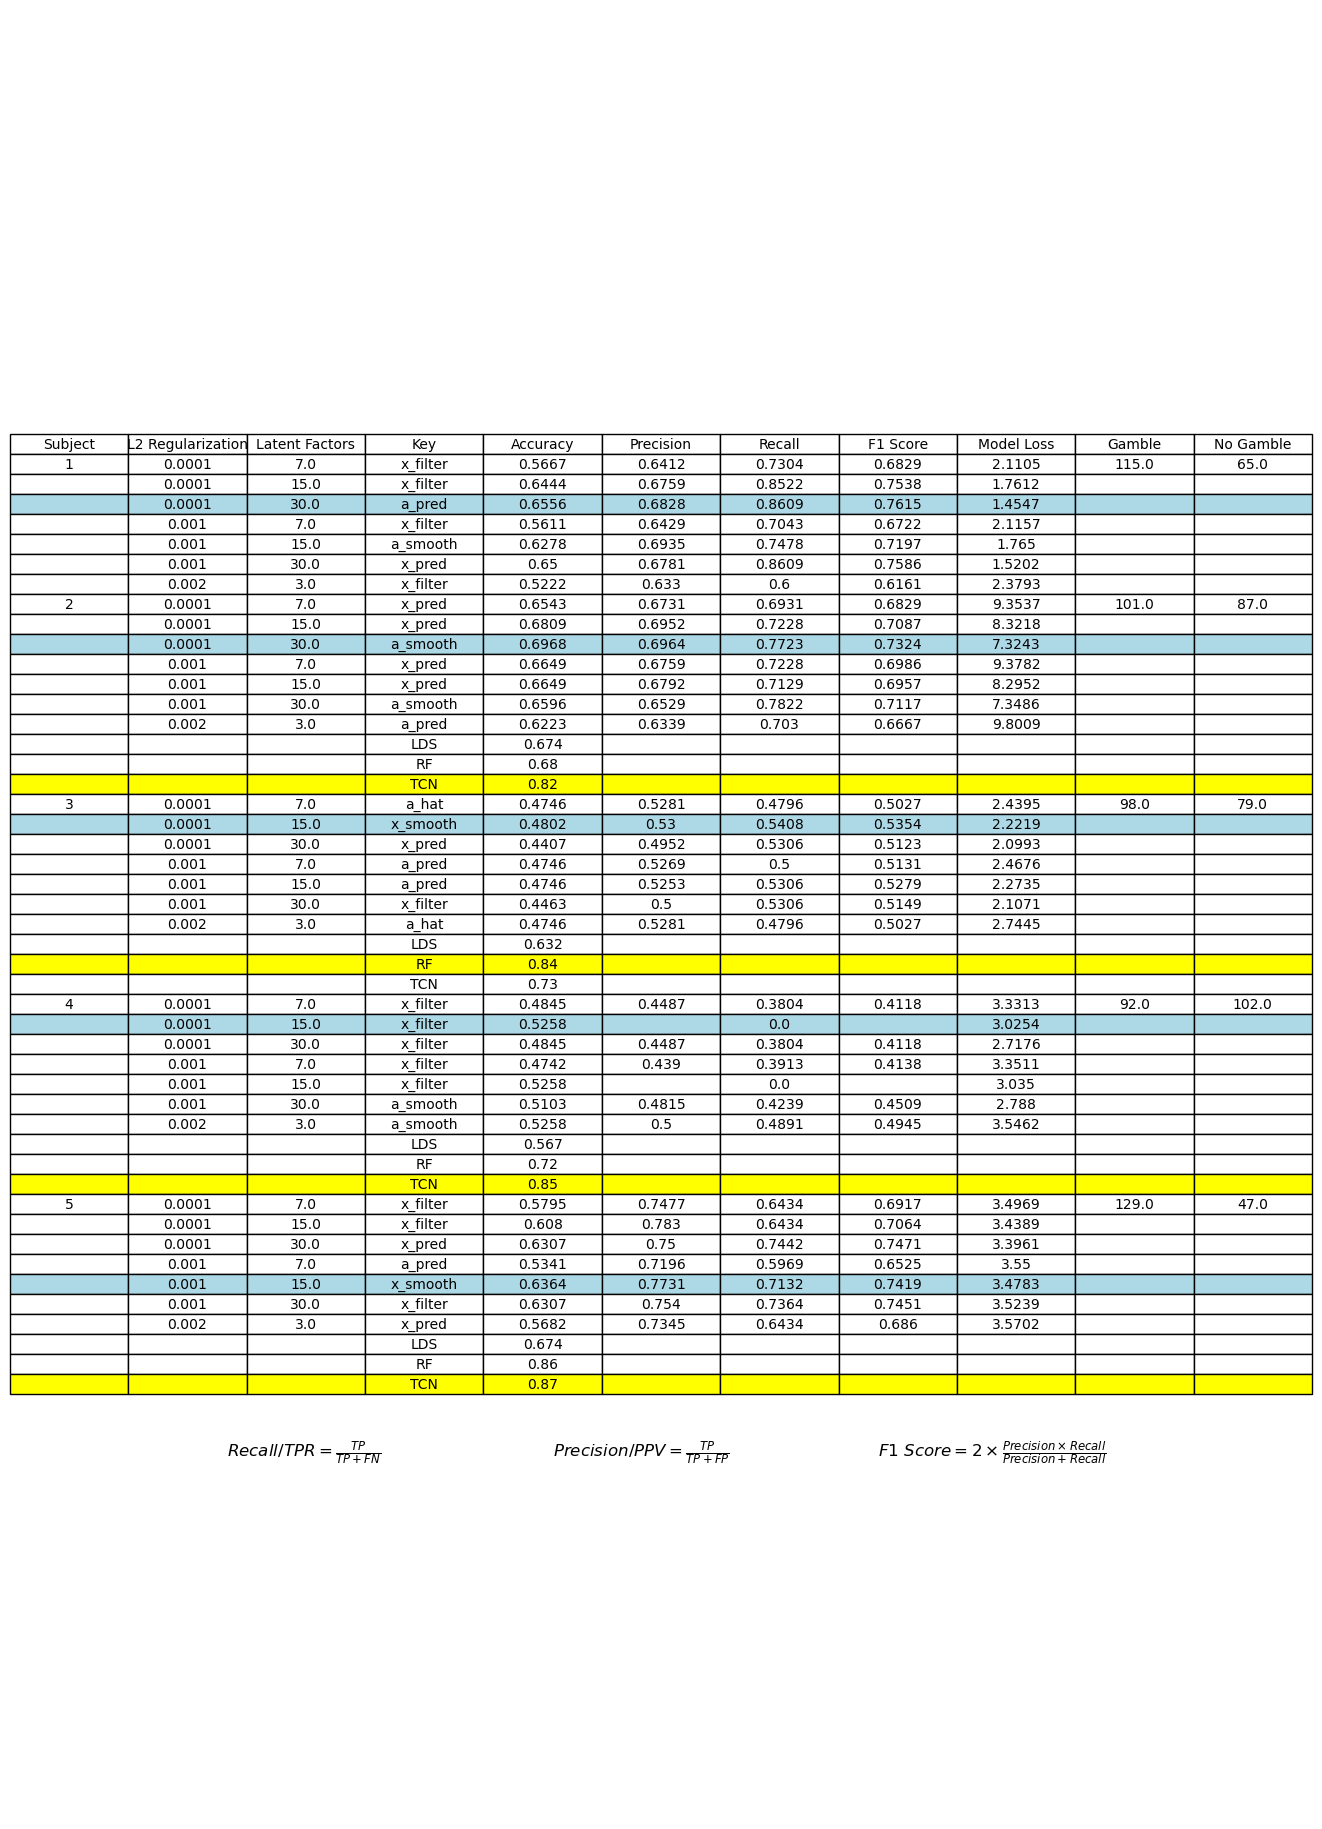

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

gamble_list = []
ng_list = []

perceptron_data = []

for subj in range(1,21):
    for key in keys:
        subj_num = f"{subj:02}" 
        save_path = os.path.join(f'./results/neural/subj_{subj_num}', f'{key}_pytorch_results.json')
        
        if os.path.exists(save_path):
            with open(save_path, "r") as json_file:           
                eval_results = json.load(json_file)

                data.append({
                    "Subject": subj_num,
                    "Key": key,
                    "Accuracy": eval_results["accuracy"],
                    "Precision": eval_results["precision"],
                    "Recall": eval_results["recall"],
                    "F1 Score": eval_results["F1_score"],
                    "Model Loss": eval_results["model_loss"]
                })

        else:
            print(f'subj {subj_num} key {key} not found')
    subj_num = f"{subj:02}"  

    f = h5py.File(f'GTH_data/GTH_s{subj_num}_decision_power_struct_nobs.mat', 'r')

    labelsset = np.array(f["power_struct"]["beh"]["gambles"]).T  

    gamble_list.append(np.sum(labelsset)) 
    ng_list.append(np.sum(labelsset==0)) 
perceptron_df = pd.DataFrame(perceptron_data)



# Load CSV
df = pd.concat([pd.read_csv("best_params.csv"), perceptron_df])
df["Key"] = df["Key"].fillna(df["Classification"])

best_hyper_df = df.loc[df.groupby("Subject")["Accuracy"].idxmax()]

df_filtered = df[df["Latent Factors"].notna()] 
best_latent_df = df_filtered.loc[df_filtered.groupby("Subject")["Accuracy"].idxmax()]

# Create highlight masks
df["Highlight"] = df.index.isin(best_hyper_df.index)  
df["Highlight_Latent"] = df.index.isin(best_latent_df.index)  

highlighted = df["Highlight"].tolist() 
highlighted_latent = df["Highlight_Latent"].tolist()  

df_display = df.drop(columns=["Highlight", "Highlight_Latent", "Classification"])
df_display = df_display.sort_values(by=["Subject", "L2 Regularization", "Latent Factors"])

df_display = df_display.round({"Accuracy": 4, "Precision": 4, "Recall": 4, "F1 Score": 4, "Model Loss": 4})

df_display.loc[~df_display["Subject"].duplicated(), "Gamble"] = df_display["Subject"].map(lambda s: gamble_list[s-1])
df_display.loc[~df_display["Subject"].duplicated(), "No Gamble"] = df_display["Subject"].map(lambda s: ng_list[s-1])

df_display["Subject"] = df_display["Subject"].mask(df_display["Subject"].duplicated(), "")

# Convert NaN values to empty strings
df_display = df_display.fillna("").head(47)
formatted_values = df_display.astype(str).values

fig, ax = plt.subplots(figsize=(14, len(df_display) * 0.5))
ax.axis('tight')
ax.axis('off')



table = ax.table(cellText=formatted_values, colLabels=df_display.columns, cellLoc='center', loc='center')

for i in range(len(df_display)):  
    if highlighted[i]:  
        for j in range(len(df_display.columns)):  
            table[(i + 1, j)].set_facecolor("yellow")  
    if highlighted_latent[i]: 
        for j in range(len(df_display.columns)):  
            table[(i + 1, j)].set_facecolor("lightblue")  


table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
equation_y=0.2
ax.text(0.1, equation_y, r"$Recall/TPR = \frac{TP}{TP + FN}$", fontsize=12, transform=ax.transAxes)
ax.text(0.4, equation_y, r"$Precision/PPV = \frac{TP}{TP + FP}$", fontsize=12, transform=ax.transAxes)
ax.text(0.7, equation_y, r"$F1 \ Score = 2 \times \frac{Precision \times Recall}{Precision + Recall}$", fontsize=12, transform=ax.transAxes)

output_dir = "output"  
os.makedirs(output_dir, exist_ok=True)

image_filename = os.path.join(output_dir, "param_table.png")
plt.savefig(image_filename, bbox_inches='tight', dpi=300)
print(f"Table image saved as {image_filename}")


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

gamble_list = []
ng_list = []
keys = "x_filter"

for subj in range(1,21):

    subj_num = f"{subj:02}" 

    lin_save_path = os.path.join(f'./results/neural/subj_{subj_num}', f'{key}_eval_results.json')
    save_path = os.path.join(f'./results/neural/subj_{subj_num}', f'{key}_eval_results.json')
    
    if os.path.exists(save_path):
        with open(save_path, "r") as json_file:           
            eval_results = json.load(json_file)

            # Append extracted information
            data.append({
                "Subject": subj_num,
                "Key": key,
                "Accuracy": eval_results["accuracy"],
                "Precision": eval_results["precision"],
                "Recall": eval_results["recall"],
                "F1 Score": eval_results["F1_score"],
                "Model Loss": eval_results["model_loss"]
            })

    else:
        print(f'subj {subj_num} key {key} not found')
    if os.path.exists(save_path):
        with open(save_path, "r") as json_file:           
            eval_results = json.load(json_file)

            data.append({
                "Subject": subj_num,
                "Key": key,
                "Accuracy": eval_results["accuracy"],
                "Precision": eval_results["precision"],
                "Recall": eval_results["recall"],
                "F1 Score": eval_results["F1_score"],
                "Model Loss": eval_results["model_loss"]
            })

    else:
        print(f'subj {subj_num} key {key} not found')
    subj_num = f"{subj:02}"  

    f = h5py.File(f'GTH_data/GTH_s{subj_num}_decision_power_struct_nobs.mat', 'r')

    labelsset = np.array(f["power_struct"]["beh"]["gambles"]).T  

    gamble_list.append(np.sum(labelsset)) 
    ng_list.append(np.sum(labelsset==0)) 
perceptron_df = pd.DataFrame(perceptron_data)
df = pd.DataFrame(data)
# Load CSV
df = pd.concat([df, perceptron_df])

csv_filename = os.path.join(output_dir, "best_params.csv")
best_df.to_csv(csv_filename, index=False)
print(f"Data saved to {csv_filename}")

output_dir = "./results/neural"
os.makedirs(output_dir, exist_ok=True)

df["Key"] = df["Key"].fillna(df["Classification"])

best_hyper_df = df.loc[df.groupby("Subject")["Accuracy"].idxmax()]

df_filtered = df[df["Latent Factors"].notna()] 
best_latent_df = df_filtered.loc[df_filtered.groupby("Subject")["Accuracy"].idxmax()]

# Create highlight masks
df["Highlight"] = df.index.isin(best_hyper_df.index)  
df["Highlight_Latent"] = df.index.isin(best_latent_df.index)  

highlighted = df["Highlight"].tolist() 
highlighted_latent = df["Highlight_Latent"].tolist()  

df_display = df.drop(columns=["Highlight", "Highlight_Latent", "Classification"])
df_display = df_display.sort_values(by=["Subject", "L2 Regularization", "Latent Factors"])

df_display = df_display.round({"Accuracy": 4, "Precision": 4, "Recall": 4, "F1 Score": 4, "Model Loss": 4})

df_display.loc[~df_display["Subject"].duplicated(), "Gamble"] = df_display["Subject"].map(lambda s: gamble_list[s-1])
df_display.loc[~df_display["Subject"].duplicated(), "No Gamble"] = df_display["Subject"].map(lambda s: ng_list[s-1])

df_display["Subject"] = df_display["Subject"].mask(df_display["Subject"].duplicated(), "")

# Convert NaN values to empty strings
df_display = df_display.fillna("").head(47)
formatted_values = df_display.astype(str).values

fig, ax = plt.subplots(figsize=(14, len(df_display) * 0.5))
ax.axis('tight')
ax.axis('off')



table = ax.table(cellText=formatted_values, colLabels=df_display.columns, cellLoc='center', loc='center')

for i in range(len(df_display)):  
    if highlighted[i]:  
        for j in range(len(df_display.columns)):  
            table[(i + 1, j)].set_facecolor("yellow")  
    if highlighted_latent[i]: 
        for j in range(len(df_display.columns)):  
            table[(i + 1, j)].set_facecolor("lightblue")  


table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
equation_y=0.2
ax.text(0.1, equation_y, r"$Recall/TPR = \frac{TP}{TP + FN}$", fontsize=12, transform=ax.transAxes)
ax.text(0.4, equation_y, r"$Precision/PPV = \frac{TP}{TP + FP}$", fontsize=12, transform=ax.transAxes)
ax.text(0.7, equation_y, r"$F1 \ Score = 2 \times \frac{Precision \times Recall}{Precision + Recall}$", fontsize=12, transform=ax.transAxes)

output_dir = "output"  
os.makedirs(output_dir, exist_ok=True)

image_filename = os.path.join(output_dir, "param_table.png")
plt.savefig(image_filename, bbox_inches='tight', dpi=300)
print(f"Table image saved as {image_filename}")
